In [1]:
%%html
<style>
.dashed-box {
    border: 1px dashed black !important;
#    font-size: var(--jp-content-font-size1) !important;
}

.dashed-box table {

}

.dashed-box tr {
    background-color: white !important;
}
        
.alt-tab {
    background-color: black;
    color: #ffc351;
    padding: 4px;
    font-size: 1em;
    font-weight: bold;
    font-family: monospace;
}
// add your CSS styling here
</style>


# Predição do Campeonato de Fórmula 1

## Especialização em Ciência de Dados
#### Projeto Interdisciplinar - 2o. Semestre

Grupo:
- Mateus Guilherme Fuini
- Michelle Melo Cavalcante

## Sumário

* [1. Objetivo de negócio](#section_1)
     - [1.1 Contexto](#subsection_1_1)
     - [1.2 Objetivo](#subsection_1_2)
 
 
* [2. Enquadramento de problemas de ML](#section_2)
     - [2.1 Planejamento da Solução](#subsection_2_1)
     - [2.2 Arquitetura de Solução proposta](#subsection_2_2)
     - [2.3 Configurações de pacotes e bibliotecas](#subsection_2_3)
     
         
* [3. Processamento dos dados](#section_3)
     - [3.1 Coleta de dados](#subsection_3_1)        
         - [3.1 Dados via API](#subsection_3_1_1)
         - [3.2 Dados via WEB Scraping](#subsection_3_1_2)
         - [3.3 Dados via Lambda](#subsection_3_1_3)
     - [3.2 Pré-processamento de dados](#subsection_3_2)
     - [3.3 Feature Store (Offline)](#subsection_3_3)
     - [3.4 Análise exploratório de dados (EDA)](#subsection_3_4)
     
         
* [4. Desenvolvimento do Modelo](#section_4)
     - [4.1 Treinamento do modelo](#subsection_4_1)
     - [4.2 Tuning do modelo](#subsection_4_2)
     - [4.3 Evaluate do modelo](#subsection_4_3)
     - [4.4 Resultado de previsão do modelo](#subsection_4_4)
     
         
* [5. Deploy](#section_5)
         
         
* [6. Experimentações com Sagemaker Canvas](#section_6)



<a id="section_1"></a> 
# 1. Objetivo de Negócio

----
Atualmente todas as equipes da Fórumal 1 (F1) utilizam de técnicas de Machine Learning em suas corridas. A própria empresa organizadora do campeonato usa dados recebidos dos carros e sensores na pista para interagir com os telespectadores. Segundo a AWS (https://aws.amazon.com/pt/f1/), cada carro possui cerca 300 sensores que geram cerca 1,1 milhão de pontos de dados por segundo, chegando a gerar mais 3Gb a cada volta por carro. Somando com os dados de outros setores da equipe, o volume de dados ultrapassa 40Tb a cada etapa do campeonato. Além de entreterimento, todos esses dados podem ser utilizados pelas equipes no planejamento e implementação de melhores estratégias de corridana na busca de melhorar a performance dos pilotos e provocar transformações positivas no esporte. Com tantos insights, a ciência de dados tem se tornado uma das principais ferramentas da F1. 

<a id="subsection_1_1"></a> 
## 1.1 Contexto
Ao obter dados históricos e usá-los para ensinar algoritmos de machine learning complexos, a F1 pode prever os resultados da estratégia de corrida com maior precisão para equipes, carros e pilotos. Esses modelos são então capazes de prever cenários futuros usando dados históricos conforme as corridas se desdobram para oferecer uma experiência rica e envolvente aos fãs. Este trabalho irá utilizar tais dados históricos dos campeonatos de F1 e tentar entender o que torna um piloto campeão da F1.

<a id="subsection_1_2"></a> 
## 1.2 Objetivo
Através dos dados históricos de diferentes campeonatos de fórmula 1, criar um modelo de aprendizado de máquina que estime quem seria os pilotos com maiores pontuação e ganhadores na F1.

<a id="section_2"></a> 
# 2. Enquadramento de problemas de ML

----
Temos um cenário em que queremos verificar os melhores pilotos e equipes de F1. Atingir essa meta de negócios depende parcialmente da análise histórica do desempenho desses pilotos e equipes. Neste cenário, vamos **prever o resultado de futuras corridas (GP ABU DHABI que acontecerá em 20/11/2022) com base em corridas e performances anteriores**.

<a id="subsection_2_1"></a> 
## 2.1 Planejamento da Solução
Foi utilizado como referência de framework de boas práticas o AWS Well-Architected Framework (https://docs.aws.amazon.com/wellarchitected/latest/machine-learning-lens/well-architected-machine-learning.html) direcionado para MLOps. Trata-se de práticas recomendadas para melhor sustentabilidade das soluções, além de ser buscado pelo mercado.

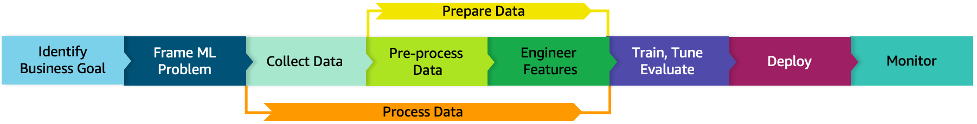


<a id="ssubsection_2_2"></a> 
## 2.2 Arquitetura de Solução proposta
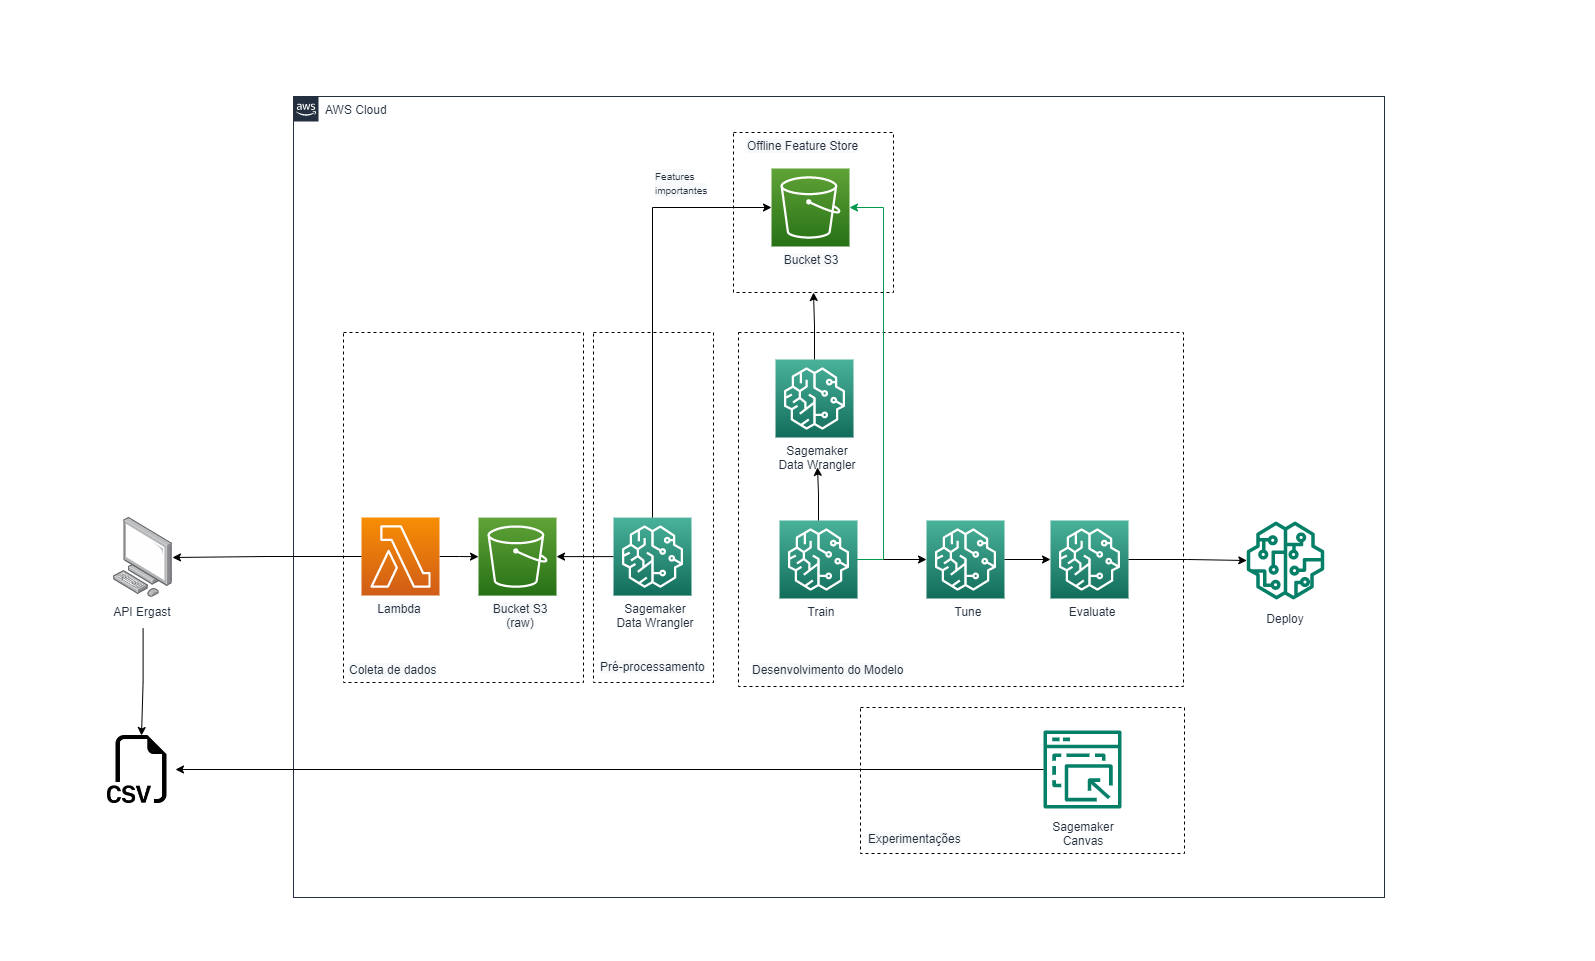

Para analisar e realizar a previsão da pontuação de pilotos de F1, utilizou-se:
- Na etapa de processamento de dados:
    - Lambda: Coleta das informações automobilísticas disponíveis no Ergast e input desses dados raw em um Bucket S3
    - Bucket S3: Armazenar dados raw trazidos do Ergast pelo Lambda
    - Sagemaker Data Wrangler: Puxar os dados raw do S3 de forma a abstrair boto3
- Na de desenvolvimento do modelo:
    - Bucket S3: Armazenar as features mais importantes, o split entre os dados para treino, validação e teste do modelo e as atualizações das features importantes.
    - Sagemaker Data Wrangler: Puxar os dados das features mais importantes do S3 de forma a abstrair boto3
    - Train, Tune e Evaluate: Treinamento, ajustes e avaliação do modelo no ambiente sagemaker 
- No deploy do modelo:
    - Utilizou-se a função pickle (.pkl)

Também se fez uso do Sagemaker Canvas. Uma solução da AWS que oferece a capacidade de usar machine learning para gerar previsões sem precisar codificar (no code).
    
Infraestrutura utilizada: ml.t3.medium. </br>
Sobre ml.t3.medium e outras infraestruturas: https://aws.amazon.com/pt/sagemaker/pricing/

<a id="subsection_2_3"></a> 
## 2.3 Configurações de pacotes e bibliotecas
Foi necessário realizar a instalação de pacotes e o import de bibliotecas.

In [2]:
pip install selenium

In [3]:
pip install awswrangler

In [229]:
pip install xgboost

In [231]:
pip install lightgbm

In [5]:
import pandas as pd
import numpy as np
from selenium import webdriver
import requests
import lxml #Necessário para o read_html()
import matplotlib.pyplot as plt
import seaborn as sns
import json
import math
import boto3
import pathlib
import os
import requests
import warnings
warnings.filterwarnings("ignore")

AttributeError: module 'numpy.linalg.lapack_lite' has no attribute '_ilp64'

<a id="section_3"></a> 
# 3. Processamento dos dados

----
Imagine um cenário em que uma empresa de manufatura deseja identificar produtos para maximizar os lucros. Atingir essa meta de negócios depende parcialmente da determinação dos produtos e do número certo a ser produzido. Neste cenário, você deseja prever as vendas futuras do produto com base nas vendas anteriores. Prever vendas futuras torna-se o problema a ser resolvido usando ML.

<a id="subsection_3_1"></a> 
## 3.1 Coleta de dados
Os dados tratam do registro histórico de dados de corridas da série de Fórmula 1 desde o início dos campeonatos mundiais em 1950.<br/>
Os dados foram adquiridos do site ergast.com via API e também foi realizado scraping da wikipedia para recuperar as informações climáticas da corrida.
Fonte: https://ergast.com/mrd/ 

<a id="subsection_3_1_1"></a> 
### Dados via API
Para recuperar as informações, são passadas as informações do ano do campeonato e da etapa da corrida, seguido do dataset que deseja recuperar. 
Por exemplo, para recuperar o dataset dos resultados da 2a corrida do campeonato de 2022, deve usar a url http://ergast.com/api/f1/2022/2/results.json.<br/>
Os dados coletados do dataset da Ergast foram:

- `race`: Tabela com dados referentes a corridas
- `circuit`: Tabela com dados referentes aos circuitos
- `results`: Tabela com dados dos resultados das corridas
- `drivers`: Tabela com dados dos pilotos
- `constructors`: Tabela com dados das equipes  
- `status`: Tabela com dados dos status da prova 
- `constructorStandings`:  
- `driverStandings`:  
- `qualifying`: Qualificação dos pilotos
- `weather`: Dados de clima

As descrições de cada um dos campos contidos nas tabelas pode ser encontradas em detalhes em http://ergast.com/docs/f1db_user_guide.txt

#### Corridas realizadas e seus Circuitos

In [7]:
races = {'raceId': [],
         'year': [],
         'round': [],
         'circuitId': [],
         'name': [],
         'date': [],
         'time': [],
         'url': [],
         'fp1_date': [],
         'fp1_time': [],
         'fp2_date': [],
         'fp2_time': [],
         'fp3_date': [],
         'fp3_time': [],
         'quali_date': [],
         'quali_time': [],
         'sprint_date': [],
         'sprint_time': [] }

circuits = {'circuitId': [],
            'circuitRef': [],
            'name': [],
            'location': [],
            'country': [],
            'lat': [],
            'lng': [],
            'alt': [],
            'url': []}

rc=1
ct=1
circid=1
for year in list(range(1950,2024)):
    url = 'https://ergast.com/api/f1/{}.json'
    r = requests.get(url.format(year))
    json = r.json()
    #print(json)
    for item in json['MRData']['RaceTable']['Races']:
        races['raceId'].append(int(rc))
        rc+=1
        try:
            races['year'].append(int(item['season']))
        except:
            races['year'].append(None)
        try:
            races['round'].append(int(item['round']))
        except:
            races['round'].append(None)
        #Circuito
        if  item['Circuit']['circuitId'] not in circuits['circuitRef']:
            try:
                circuits['circuitId'].append(ct)
            except:
                circuits['circuitId'].append(None)
            circid = ct
            ct += 1
            try:
                circuits['circuitRef'].append(item['Circuit']['circuitId'])
            except:
                circuits['circuitRef'].append(None)
            try:
                circuits['name'].append(item['Circuit']['circuitName'])
            except:
                circuits['name'].append(None)
            try:
                circuits['lat'].append(float(item['Circuit']['Location']['lat']))
            except:
                circuits['lat'].append(None)
            try:
                circuits['lng'].append(float(item['Circuit']['Location']['long']))
            except:
                circuits['lng'].append(None)
            try:
                circuits['alt'].append(float(item['Circuit']['Location']['alt']))
            except:
                circuits['alt'].append(None)
            try:
                circuits['country'].append(item['Circuit']['Location']['country'])
            except:
                circuits['country'].append(None)
            try:
                circuits['location'].append(item['Circuit']['Location']['locality'])
            except:
                circuits['location'].append(None)
            try:
                circuits['url'].append(item['Circuit']['url'])
            except:
                circuits['url'].append(None)
        else:
            circid = circuits['circuitRef'].index(item['Circuit']['circuitId'])+1
        try:
            races['circuitId'].append(circid)
        except:
            races['circuitId'].append(None)
        try:
            races['name'].append(item['raceName'])
        except:
            races['name'].append(None)
        try:
            races['date'].append(item['date'])
        except:
            races['date'].append(None)
        try:
            races['time'].append(item['time'])
        except:
            races['time'].append(None)
        try:
            races['url'].append(item['url'])
        except:
            races['url'].append(None)
        try:
            races['fp1_date'].append(item['FirstPractice']['date'])
        except:
            races['fp1_date'].append(None)
        try:
            races['fp1_time'].append(item['FirstPractice']['time'])
        except:
            races['fp1_time'].append(None)
        try:
            races['fp2_date'].append(item['SecondPractice']['date'])
        except:
            races['fp2_date'].append(None)
        try:
            races['fp2_time'].append(item['SecondPractice']['time'])
        except:
            races['fp2_time'].append(None)
        try:
            races['fp3_date'].append(item['ThirdPractice']['date'])
        except:
            races['fp3_date'].append(None)
        try:
            races['fp3_time'].append(item['ThirdPractice']['time'])
        except:
            races['fp3_time'].append(None)
        try:
            races['quali_date'].append(item['Qualifying']['date'])
        except:
            races['quali_date'].append(None)
        try:
            races['quali_time'].append(item['Qualifying']['time'])
        except:
            races['quali_time'].append(None)
        try:
            races['sprint_date'].append(item['Sprint']['date'])
        except:
            races['sprint_date'].append(None)
        try:
            races['sprint_time'].append(item['Sprint']['time'])
        except:
            races['sprint_time'].append(None)

races = pd.DataFrame(races)
circuits = pd.DataFrame(circuits)

circuits.to_csv('./datasets/circuits.csv', index = False)
races.to_csv('./datasets/races.csv', index = False)

#### Resultados, pilotos e equipes que participaram

In [8]:
# matriz que armazena a temporada e as corridas de de cada uma
rounds = []
for year in np.array(races.year.unique()):
    rounds.append([year, list(races[races.year == year]['round'])])

results={'resultId':[],
         'raceId':[],
         'driverId':[],
         'constructorId':[],
         'number':[],
         'grid':[],
         'position':[],
         'positionText':[],
         'positionOrder':[],
         'points':[],
         'laps':[],
         'time':[],
         'milliseconds':[],
         'fastestLap':[],
         'rank':[],
         'fastestLapTime':[],
         'fastestLapSpeed':[],
         'statusId':[]
         }

drivers = {'driverId':[],
           'driverRef':[],
           'number':[],
           'code':[],
           'forename':[],
           'surname':[],
           'dob':[],
           'nationality':[],
           'url':[]
}

constructors = {'constructorId':[],
                'constructorRef':[],
                'name':[],
                'nationality':[],
                'url':[]
}

status = {'statusId':[],
          'status':[]
}
#races = pd.read_csv('./data/races.csv')
rs=dr=ct=st=1
results_rounds = rounds
for n in list(range(len(rounds))):
    for i in rounds[n][1]:
        url = 'http://ergast.com/api/f1/{}/{}/results.json'
        r = requests.get(url.format(results_rounds[n][0], i))
        json = r.json()
        currentRound = races.query(f'year=={results_rounds[n][0]} & round=={i}')
        if len(json['MRData']['RaceTable']['Races'])>0:
            print(f'{results_rounds[n][0]} {i}')
            for item in json['MRData']['RaceTable']['Races'][0]['Results']:
                results['resultId'].append(rs)
                rs+=1
                results['raceId'].append(currentRound.iloc[0]['raceId'])
                #Driver
                if item['Driver']['driverId'] not in drivers['driverRef']:
                    drivers['driverId'].append(dr)
                    driverid = dr
                    dr+=1
                    try: drivers['driverRef'].append(item['Driver']['driverId'])
                    except: drivers['driverRef'].append(None);
                    try: drivers['number'].append(int(item['Driver']['permanentNumber']))
                    except: drivers['number'].append(None);
                    try: drivers['code'].append(item['Driver']['code'])
                    except: drivers['code'].append(None);
                    try: drivers['forename'].append(item['Driver']['givenName'])
                    except: drivers['forename'].append(None);
                    try: drivers['surname'].append(item['Driver']['familyName'])
                    except: drivers['surname'].append(None);
                    try: drivers['dob'].append(item['Driver']['dateOfBirth'])
                    except: drivers['dob'].append(None);
                    try: drivers['nationality'].append(item['Driver']['nationality'])
                    except: drivers['nationality'].append(None);
                    try: drivers['url'].append(item['Driver']['url'])
                    except: drivers['url'].append(None);
                else:
                    driverid = drivers['driverRef'].index(item['Driver']['driverId'])+1
                results['driverId'].append(driverid)

                if item['Constructor']['constructorId'] not in constructors['constructorRef']:
                    constructors['constructorId'].append(ct)
                    constructorid = ct
                    ct+=1
                    try: constructors['constructorRef'].append(item['Constructor']['constructorId'])
                    except: constructors['constructorRef'].append(None)
                    try: constructors['name'].append(item['Constructor']['name'])
                    except: constructors['name'].append(None)
                    try: constructors['nationality'].append(item['Constructor']['nationality'])
                    except:  constructors['nationality'].append(None)
                    try: constructors['url'].append(item['Constructor']['url'])
                    except: constructors['url'].append(None)
                else:
                    constructorid = constructors['constructorRef'].index(item['Constructor']['constructorId'])+1
                results['constructorId'].append(constructorid)

                if item['status'] not in status['status']:
                    status['statusId'].append(st)
                    statusId=st
                    st+=1
                    status['status'].append(item['status'])
                else:
                    statusId = status['status'].index(item['status'])+1
                results['statusId'].append(statusId)

                try: results['number'].append(int(item['number']))
                except: results['number'].append(None)
                try: results['grid'].append(int(item['grid']))
                except: results['grid'].append(None)
                try: results['position'].append(int(item['position']) if item['positionText']==item['position'] else None)
                except: results['position'].append(None)
                try: results['positionText'].append(item['positionText'])
                except:  results['positionText'].append(None)
                try: results['positionOrder'].append(item['position'])
                except: results['positionOrder'].append(None)
                try: results['points'].append(int(item['points']))
                except: results['points'].append(None)
                try: results['laps'].append(item['laps'])
                except: results['laps'].append(None)
                try: results['time'].append(item['Time']['time'])
                except: results['time'].append(None)
                try: results['milliseconds'].append(int(item['Time']['millis']))
                except:  results['milliseconds'].append(None)
                try: results['fastestLap'].append(int(item['FastestLap']['lap']))
                except: results['fastestLap'].append(None)
                try: results['rank'].append(int(item['FastestLap']['rank']))
                except: results['rank'].append(None)
                try: results['fastestLapTime'].append(item['FastestLap']['Time']['time'])
                except: results['fastestLapTime'].append(None)
                try: results['fastestLapSpeed'].append(item['FastestLap']['AverageSpeed']['speed'])
                except: results['fastestLapSpeed'].append(None)
        else:
            print(f'Error : {results_rounds[n][0]} :{i}')


constructors['constructorId'].append(ct)
ct+=1
constructors['constructorRef'].append('apollon')
constructors['name'].append('Apollon')
constructors['nationality'].append('Swiss')
constructors['url'].append('https://en.wikipedia.org/wiki/Apollon_(Formula_One)')
constructors['constructorId'].append(ct)
ct+=1
constructors['constructorRef'].append('mcguire')
constructors['name'].append('McGuire')
constructors['nationality'].append('Australian')
constructors['url'].append('https://en.wikipedia.org/wiki/McGuire_(Formula_One)')
constructors['constructorId'].append(ct)
ct+=1
constructors['constructorRef'].append('life')
constructors['name'].append('Life Racing Engines')
constructors['nationality'].append('Italian')
constructors['url'].append('https://en.wikipedia.org/wiki/Life_Racing_Engines')

results = pd.DataFrame(results)
results.to_csv('./datasets/results.csv', index = False)
drivers = pd.DataFrame(drivers)
drivers.to_csv('./datasets/drivers.csv', index = False)
constructors = pd.DataFrame(constructors)
constructors.to_csv('./datasets/constructors.csv', index = False)
status = pd.DataFrame(status)
status.to_csv('./datasets/status.csv', index = False)

Error : 2022 :22


#### Classificação das equipes

In [9]:
constructorStandings={'constructorStandingsId':[],
                       'raceId':[],
                       'constructorId':[],
                       'points':[],
                       'position':[],
                       'positionText':[],
                       'wins':[]
}
constructor_rounds = rounds
races = pd.read_csv('./datasets/races.csv')
constructors = pd.read_csv('./datasets/constructors.csv')
cs=1
err=999

for n in list(range(len(constructor_rounds))):
    for i in constructor_rounds[n][1]:
        url = 'https://ergast.com/api/f1/{}/{}/constructorStandings.json'
        r = requests.get(url.format(constructor_rounds[n][0], i))
        json = r.json()
        print(f'{constructor_rounds[n][0]} {i}')
        currentRound = races.query(f'year=={constructor_rounds[n][0]} & round=={i}')
        if len(json['MRData']['StandingsTable']['StandingsLists'])>0:
            for item in json['MRData']['StandingsTable']['StandingsLists'][0]['ConstructorStandings']:
                constructorStandings['constructorStandingsId'].append(cs)
                cs+=1
                constructorStandings['raceId'].append(currentRound.iloc[0]['raceId'])
                try: constructorid = constructors.query(f'constructorRef=="{item["Constructor"]["constructorId"]}"').iloc[0]['constructorId']
                except:
                    constructorid = err
                    err+=1
                    print(f" {item['Constructor']['constructorId']} - {err} ")
                constructorStandings['constructorId'].append(int(constructorid))
                constructorStandings['points'].append(item['points'])
                constructorStandings['position'].append(int(item['position']))
                constructorStandings['positionText'].append(item['positionText'])
                constructorStandings['wins'].append(int(item['wins']))

constructorStandings = pd.DataFrame(constructorStandings)
constructorStandings.to_csv('./datasets/constructor_standings.csv', index = False)
constructorStandings

,constructorStandingsId,raceId,constructorId,points,position,positionText,wins
0,1,65,8,8,1,1,1
1,2,65,6,6,2,2,0
2,3,65,4,3,3,3,0
3,4,66,8,16,1,1,2
4,5,66,6,12,2,2,0
...,...,...,...,...,...,...,...
12916,12917,1078,1,55,6,6,0
12917,12918,1078,61,50,7,7,0
12918,12919,1078,201,37,8,8,0
12919,12920,1078,203,35,9,9,0


#### Classificação dos Pilotos

In [10]:
driverStandings={'driverStandingsId':[],
                 'raceId':[],
                 'driverId':[],
                 'points':[],
                 'position':[],
                 'positionText':[],
                 'wins':[]
}
driver_rounds = rounds
ds=1
races = pd.read_csv('./datasets/races.csv')
drivers = pd.read_csv('./datasets/drivers.csv')

for n in list(range(len(driver_rounds))):
    for i in driver_rounds[n][1]:
        url = 'https://ergast.com/api/f1/{}/{}/driverStandings.json'
        r = requests.get(url.format(driver_rounds[n][0], i))
        json = r.json()
        print(f'{driver_rounds[n][0]} {i}')
        currentRound = races.query(f'year=={driver_rounds[n][0]} & round=={i}')
        if len(json['MRData']['StandingsTable']['StandingsLists'])>0:
            for item in json['MRData']['StandingsTable']['StandingsLists'][0]['DriverStandings']:
                driverStandings['driverStandingsId'].append(ds)
                ds+=1
                driverStandings['raceId'].append(int(currentRound.iloc[0]['raceId']))
                driverid = drivers.query(f'driverRef=="{item["Driver"]["driverId"]}"').iloc[0]['driverId']
                driverStandings['driverId'].append(int(driverid))
                driverStandings['points'].append(item['points'])
                driverStandings['position'].append(int(item['position']))
                driverStandings['positionText'].append(item['positionText'])
                driverStandings['wins'].append(int(item['wins']))

driverStandings = pd.DataFrame(driverStandings)
driverStandings['raceId']=driverStandings['raceId'].astype(int)
driverStandings.to_csv('./datasets/driver_standings.csv', index = False)
driverStandings.tail()

,driverStandingsId,raceId,driverId,points,position,positionText,wins
27553,27554,1078,833,6,18,18,0
27554,27555,1078,825,4,19,19,0
27555,27556,1078,827,2,20,20,0
27556,27557,1078,834,2,21,21,0
27557,27558,1078,786,0,22,22,0


#### Informações sobre a etapa de qualificação

In [11]:
qualifying = {'qualifyId':[],
              'raceId':[],
              'driverId':[],
              'constructorId':[],
              'number':[],
              'position':[],
              'q1':[],
              'q2':[],
              'q3':[]
            }
qr=1
races = pd.read_csv('./datasets/races.csv')
drivers = pd.read_csv('./datasets/drivers.csv')
constructors = pd.read_csv('./datasets/constructors.csv')
qualifying_races  = rounds
for n in list(range(len(qualifying_races))):
    for i in qualifying_races[n][1]:
        url = 'http://ergast.com/api/f1/{}/{}/qualifying.json'
        r = requests.get(url.format(rounds[n][0], i))
        json = r.json()
        currentRound = races.query(f'year=={qualifying_races[n][0]} & round=={i}')
        print(f'{qualifying_races[n][0]} {i}')
        if len(json['MRData']['RaceTable']['Races'])>0:
            for item in json['MRData']['RaceTable']['Races'][0]['QualifyingResults']:
                qualifying['qualifyId'].append(qr)
                qr+=1
                qualifying['raceId'].append(currentRound.iloc[0]['raceId'])
                driverid = drivers.query(f'driverRef=="{item["Driver"]["driverId"]}"').iloc[0]['driverId']
                qualifying['driverId'].append(driverid)
                constructorid = constructors.query(f'constructorRef=="{item["Constructor"]["constructorId"]}"').iloc[0]['constructorId']
                qualifying['constructorId'].append(constructorid)
                qualifying['number'].append(int(item['number']))
                qualifying['position'].append(int(item['position']))
                qualifying['q1'].append(item['Q1'])
                try: qualifying['q2'].append(item['Q2'])
                except: qualifying['q2'].append(None)
                try: qualifying['q3'].append(item['Q3'])
                except: qualifying['q3'].append(None)
qualifying = pd.DataFrame(qualifying)
qualifying.to_csv('./datasets/qualifying.csv', index = False)

A partir de 2021 foram inseridas no campeonato algumas corridas denominadas Sprints, corridas rápidas, de no máximo 100km e de 25 a 30 minutos de duração. Esta corrida defini o grid de largada e também permite que os pilotos e equipes recebam alguns pontos a mais no campeonato. Não utilizamos estes dados por ser exclusivo dos dois últimos campeonatos.

<a id="subsection_3_1_2"></a> 
### Dados via WEB Scraping
As informações da url que contêm os dados de cada corrida estão no dataset races. Como estas páginas de internet segue a estruturas padronizadas (wikipedia), foi feito a leitura de cada página e procurado pelo elemento 'Weather'. 

In [12]:
info = []
weather = races.iloc[:,[0]]
for link in races.url:
    try:
        df = pd.read_html(link)[0]
        df.head()
        if 'Weather' in list(df.iloc[:,0]):
            n = list(df.iloc[:,0]).index('Weather')
            info.append(df.iloc[n,1])
        else:
            df = pd.read_html(link)[1]
            if 'Weather' in list(df.iloc[:,0]):
                n = list(df.iloc[:,0]).index('Weather')
                info.append(df.iloc[n,1])
            else:
                df = pd.read_html(link)[2]
                if 'Weather' in list(df.iloc[:,0]):
                    n = list(df.iloc[:,0]).index('Weather')
                    info.append(df.iloc[n,1])
                else:
                    df = pd.read_html(link)[3]
                    if 'Weather' in list(df.iloc[:,0]):
                        n = list(df.iloc[:,0]).index('Weather')
                        info.append(df.iloc[n,1])
                    else:
                        driver = webdriver.Chrome()
                        driver.get(link)

                        # click language button
                        button = driver.find_element_by_link_text('Italiano')
                        button.click()

                        clima = driver.find_element_by_xpath('//*[@id="mw-content-text"]/div/table[1]/tbody/tr[9]/td').text
                        info.append(clima)

    except:
        print(link)
        info.append(None)

weather['weather'] = info
weather = pd.DataFrame(weather)
weather.to_csv('./datasets/weather.csv')

http://en.wikipedia.org/wiki/2019_Spanish_Grand_Prix
http://en.wikipedia.org/wiki/2022_Abu_Dhabi_Grand_Prix


<a id="subsection_3_1_3"></a>
### Dados (experimentação) via Lambda
Uma Lambda foi utilizada para fins experimentais, uma vez que, via API direta e WEB Scraping não existem custos associados. No caso da utlização da Lambda, o seu custo e uso compensa para a finalidade de automatizar a coleta de dados. Pensando nisso, fez-se experimentos para mostrar que a automação é possível e fácil de ser implementada.

Com o Lambda, foram extraídas as tabelas `Races` e `Circuits` (abordadas anteriormente) e inseridas em um bucket S3 de nome `upload-f1`.

In [ ]:
#Código deve ser inserido no AWS Lambda

# import json
# import urllib.parse
# import boto3
# import requests
# import csv
# from collections import defaultdict

# print('Loading function')
# s3 = boto3.client('s3')

# def lambda_handler(event, context):    
#     bucket='upload-f1'

#     races = {'raceId': [],
#              'year': [],
#              'round': [],
#              'circuitId': [],
#              'name': [],
#              'date': [],
#              'time': [],
#              'url': [],
#              'fp1_date': [],
#              'fp1_time': [],
#              'fp2_date': [],
#              'fp2_time': [],
#              'fp3_date': [],
#              'fp3_time': [],
#              'quali_date': [],
#              'quali_time': [],
#              'sprint_date': [],
#              'sprint_time': [] }
    
#     circuits = {'circuitId': [],
#                 'circuitRef': [],
#                 'name': [],
#                 'location': [],
#                 'country': [],
#                 'lat': [],
#                 'lng': [],
#                 'alt': [],
#                 'url': []}
                    
#     rc=1
#     ct=1
#     circid=1
    
#     for year in list(range(1950,2022)):
#         url = 'https://ergast.com/api/f1/{}.json'
#         r = requests.get(url.format(year))
#         json_ = r.json()
#         print(json)
        
          #Races
#         for item in json_['MRData']['RaceTable']['Races']:
#             races['raceId'].append(int(rc))
#             rc+=1
#             try:
#                 races['year'].append(int(item['season']))
#             except:
#                 races['year'].append(None)
#             try:
#                 races['round'].append(int(item['round']))
#             except:
#                 races['round'].append(None)
           
#         #Circuits    
#             if  item['Circuit']['circuitId'] not in circuits['circuitRef']:
#                 try:
#                     circuits['circuitId'].append(ct)
#                 except:
#                     circuits['circuitId'].append(None)
#                 circid = ct
#                 ct += 1
#                 try:
#                     circuits['circuitRef'].append(item['Circuit']['circuitId'])
#                 except:
#                     circuits['circuitRef'].append(None)
#                 try:
#                     circuits['name'].append(item['Circuit']['circuitName'])
#                 except:
#                     circuits['name'].append(None)
#                 try:
#                     circuits['lat'].append(float(item['Circuit']['Location']['lat']))
#                 except:
#                     circuits['lat'].append(None)
#                 try:
#                     circuits['lng'].append(float(item['Circuit']['Location']['long']))
#                 except:
#                     circuits['lng'].append(None)
#                 try:
#                     circuits['alt'].append(float(item['Circuit']['Location']['alt']))
#                 except:
#                     circuits['alt'].append(None)
#                 try:
#                     circuits['country'].append(item['Circuit']['Location']['country'])
#                 except:
#                     circuits['country'].append(None)
#                 try:
#                     circuits['location'].append(item['Circuit']['Location']['locality'])
#                 except:
#                     circuits['location'].append(None)
#                 try:
#                     circuits['url'].append(item['Circuit']['url'])
#                 except:
#                     circuits['url'].append(None)
#             else:
#                 circid = circuits['circuitRef'].index(item['Circuit']['circuitId'])+1
#             try:
#                 races['circuitId'].append(circid)
#             except:
#                 races['circuitId'].append(None)
#             try:
#                 races['name'].append(item['raceName'])
#             except:
#                 races['name'].append(None)
#             try:
#                 races['date'].append(item['date'])
#             except:
#                 races['date'].append(None)
#             try:
#                 races['time'].append(item['time'])
#             except:
#                 races['time'].append(None)
#             try:
#                 races['url'].append(item['url'])
#             except:
#                 races['url'].append(None)
#             try:
#                 races['fp1_date'].append(item['FirstPractice']['date'])
#             except:
#                 races['fp1_date'].append(None)
#             try:
#                 races['fp1_time'].append(item['FirstPractice']['time'])
#             except:
#                 races['fp1_time'].append(None)
#             try:
#                 races['fp2_date'].append(item['SecondPractice']['date'])
#             except:
#                 races['fp2_date'].append(None)
#             try:
#                 races['fp2_time'].append(item['SecondPractice']['time'])
#             except:
#                 races['fp2_time'].append(None)
#             try:
#                 races['fp3_date'].append(item['ThirdPractice']['date'])
#             except:
#                 races['fp3_date'].append(None)
#             try:
#                 races['fp3_time'].append(item['ThirdPractice']['time'])
#             except:
#                 races['fp3_time'].append(None)
#             try:
#                 races['quali_date'].append(item['Qualifying']['date'])
#             except:
#                 races['quali_date'].append(None)
#             try:
#                 races['quali_time'].append(item['Qualifying']['time'])
#             except:
#                 races['quali_time'].append(None)
#             try:
#                 races['sprint_date'].append(item['Sprint']['date'])
#             except:
#                 races['sprint_date'].append(None)
#             try:
#                 races['sprint_time'].append(item['Sprint']['time'])
#             except:
#                 races['sprint_time'].append(None)
                                
#                 #return json    
    
#     fileName1 = 'Ergast-races-19502022'+ '.json'
#     fileName2 = 'Ergast-circuits-19502022'+ '.json'
    
#     uploadByteStream1 = bytes(json.dumps(races).encode('UTF-8'))
#     uploadByteStream2 = bytes(json.dumps(circuits).encode('UTF-8'))
    
#     s3.put_object(Bucket=bucket, Key=fileName1, Body=uploadByteStream1)
#     s3.put_object(Bucket=bucket, Key=fileName2, Body=uploadByteStream2)
    
#     print('Put Complete')

In [ ]:
#Uso dos dados a partir do S3

# bucket = 'upload-f1' #Identificação do bucket em que o lambda armazenou os dados

# data_key_races = 'Ergast-races-20122022.json'
# data_key_circuits = 'Ergast-circuits-20122022.json'

# data_location_races = 's3://{}/{}'.format(bucket, data_key_races)
# data_location_circuits = 's3://{}/{}'.format(bucket, data_key_circuits)

# import awswrangler as wr #importação do sagemaker wrangler (abstrai o boto3 que pode ser usado também para chamar dados do S3)

# races_ = wr.s3.read_json(data_location_races)
# races = pd.DataFrame(races_)
# races.to_csv('races.csv')

# circuits_ = wr.s3.read_json(data_location_circuits)
# circuits = pd.DataFrame(circuits_)
# circuits.to_csv('circuits.csv')

# #Para visualização dos arquivos
# races.head(3)

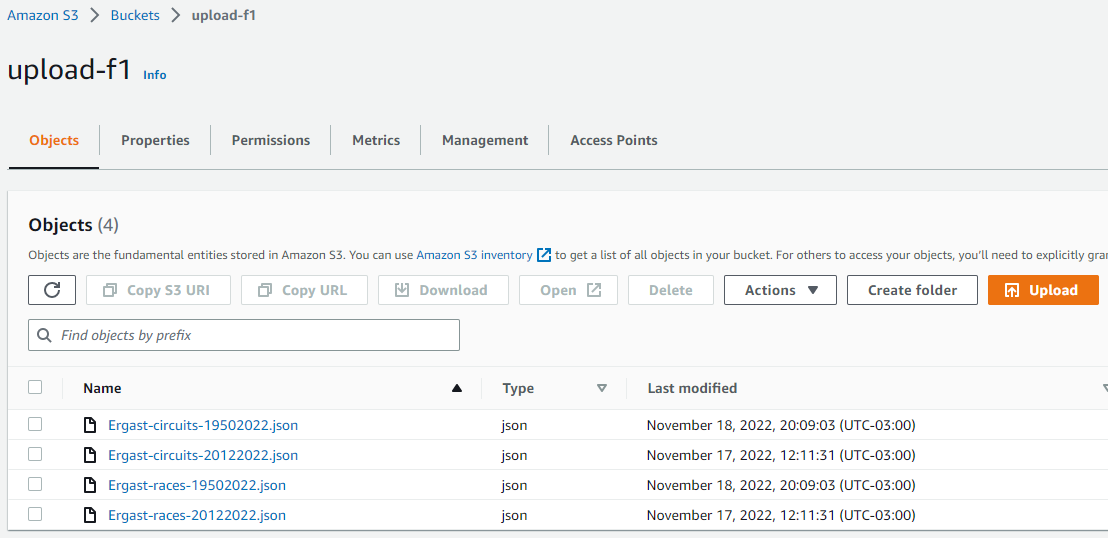

<a id="section_3_2"></a>
## 3.2 Pré-processamento
O objetivo do pré-processamento de dados é colocar os dados na forma e qualidade corretas para o treinamento. As estratégias de pré-processamento de dados utilidas incluiram: limpeza de dados, substituições (renomeações) e inclusão de parâmetros.

<a id="subsection_3_2_1"></a>
### Análise inicial e merge de todas as tabelas
A seguir os dados estruturados, recuperados anteriormente, serão mesclados em um único dataset, que terá os seguintes atributos finais

In [117]:
# Busca via .CSV (Nesta etapa deu-se prioridade a busca .csv para agilizar processo de análises e evitar custos com o lamda)
races = pd.read_csv('./datasets/races.csv',sep=',',low_memory=False)
drivers = pd.read_csv('./datasets/drivers.csv',sep=',',low_memory=False)
constructors = pd.read_csv('./datasets/constructors.csv',sep=',',low_memory=False)
circuits = pd.read_csv('./datasets/circuits.csv',sep=',',low_memory=False)
qualifying = pd.read_csv('./datasets/qualifying.csv',sep=',',low_memory=False)
results = pd.read_csv('./datasets/results.csv',sep=',',low_memory=False)
driver_standings = pd.read_csv('./datasets/driver_standings.csv')
constructor_standings = pd.read_csv('./datasets/constructor_standings.csv')
weather = pd.read_csv('./datasets/weather.csv')

# Busca via Wrangler
# races = wr.s3.read_json(data_location_races)

In [118]:
races=races.convert_dtypes()
print(races.shape)
races.tail()

(1079, 18)


,raceId,year,round,circuitId,name,date,time,url,fp1_date,fp1_time,fp2_date,fp2_time,fp3_date,fp3_time,quali_date,quali_time,sprint_date,sprint_time
1074,1075,2022,18,53,Japanese Grand Prix,2022-10-09,05:00:00Z,http://en.wikipedia.org/wiki/2022_Japanese_Gra...,2022-10-07,03:00:00Z,2022-10-07,06:00:00Z,2022-10-08,03:00:00Z,2022-10-08,06:00:00Z,<NA>,<NA>
1075,1076,2022,19,69,United States Grand Prix,2022-10-23,19:00:00Z,http://en.wikipedia.org/wiki/2022_United_State...,2022-10-21,19:00:00Z,2022-10-21,22:00:00Z,2022-10-22,19:00:00Z,2022-10-22,22:00:00Z,<NA>,<NA>
1076,1077,2022,20,23,Mexico City Grand Prix,2022-10-30,20:00:00Z,http://en.wikipedia.org/wiki/2022_Mexican_Gran...,2022-10-28,18:00:00Z,2022-10-28,21:00:00Z,2022-10-29,17:00:00Z,2022-10-29,20:00:00Z,<NA>,<NA>
1077,1078,2022,21,37,Brazilian Grand Prix,2022-11-13,18:00:00Z,http://en.wikipedia.org/wiki/2022_Brazilian_Gr...,2022-11-11,15:30:00Z,2022-11-12,15:30:00Z,<NA>,<NA>,2022-11-11,19:00:00Z,2022-11-12,19:30:00Z
1078,1079,2022,22,66,Abu Dhabi Grand Prix,2022-11-20,13:00:00Z,http://en.wikipedia.org/wiki/2022_Abu_Dhabi_Gr...,2022-11-18,10:00:00Z,2022-11-18,13:00:00Z,2022-11-19,11:00:00Z,2022-11-19,14:00:00Z,<NA>,<NA>


In [119]:
results = results.convert_dtypes()
print(results.shape)
results.head()

(25367, 18)


,resultId,raceId,driverId,constructorId,number,grid,position,positionText,positionOrder,points,laps,time,milliseconds,fastestLap,rank,fastestLapTime,fastestLapSpeed,statusId
0,1,1,1,1,2,1,1,1,1,9,70,2:13:23.6,8003600,<NA>,<NA>,<NA>,<NA>,1
1,2,1,2,1,3,2,2,2,2,6,70,+2.6,8006200,<NA>,<NA>,<NA>,<NA>,1
2,3,1,3,1,4,4,3,3,3,4,70,+52.0,8055600,<NA>,<NA>,<NA>,<NA>,1
3,4,1,4,2,14,6,4,4,4,3,68,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,2
4,5,1,5,2,15,9,5,5,5,2,68,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,2


In [120]:
results[results.driverId==637]

,resultId,raceId,driverId,constructorId,number,grid,position,positionText,positionOrder,points,laps,time,milliseconds,fastestLap,rank,fastestLapTime,fastestLapSpeed,statusId
9508,9509,389,637,157,19,16,<NA>,R,26,0,8,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,54
9515,9516,390,637,157,19,13,6,6,6,1,72,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,3
9542,9543,391,637,157,19,19,6,6,6,1,68,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,2
9591,9592,392,637,157,19,0,<NA>,F,28,0,0,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,60
9610,9611,393,637,157,19,13,<NA>,R,19,0,35,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,54
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
13900,13901,547,637,114,8,2,1,1,1,10,53,1:40:27.912,6027912,<NA>,<NA>,<NA>,<NA>,1
13924,13925,548,637,114,8,1,1,1,1,10,79,1:43:27.476,6207476,<NA>,<NA>,<NA>,<NA>,1
13960,13961,549,637,137,2,1,<NA>,R,13,0,55,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,19
13999,14000,550,637,137,2,1,<NA>,R,24,0,0,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,18


In [121]:
print(weather.shape)
weather.head()

(1079, 3)


,Unnamed: 0,raceId,weather
0,0,1,"Sunny, mild, dry."
1,1,2,NaN
2,2,3,Rainy
3,3,4,"Warm, dry and sunny"
4,4,5,"Warm, dry and sunny"


In [122]:
print(driver_standings.shape)
driver_standings.head()

(27558, 7)


,driverStandingsId,raceId,driverId,points,position,positionText,wins
0,1,1,1,9.0,1,1,1
1,2,1,2,6.0,2,2,0
2,3,1,3,4.0,3,3,0
3,4,1,4,3.0,4,4,0
4,5,1,5,2.0,5,5,0


In [123]:
qualifying=qualifying.convert_dtypes()
drivers=drivers.convert_dtypes()
constructors=constructors.convert_dtypes()
circuits=circuits.convert_dtypes()

In [124]:
#Criar um único dataset e deixar somente as features úteis

dfmerge1 = pd.merge(races,results,how='inner',on=['raceId'])
#dfmerge1 = dfmerge1.drop(['round','circuitId','time','url','fp1_date', 'fp1_time', 'fp2_date', 'fp2_time', 'fp3_date', 'fp3_time', 'quali_date', 'quali_time', 'sprint_date', 'sprint_time','resultId', 'number', 'position', 'positionText','laps', 'time_y', 'milliseconds', 'fastestLap', 'rank', 'fastestLapTime', 'fastestLapSpeed'],axis=1)
dfmerge1.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 25367 entries, 0 to 25366
Data columns (total 35 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   raceId           25367 non-null  Int64  
 1   year             25367 non-null  Int64  
 2   round            25367 non-null  Int64  
 3   circuitId        25367 non-null  Int64  
 4   name             25367 non-null  string 
 5   date             25367 non-null  string 
 6   time_x           7351 non-null   string 
 7   url              25367 non-null  string 
 8   fp1_date         860 non-null    string 
 9   fp1_time         420 non-null    string 
 10  fp2_date         860 non-null    string 
 11  fp2_time         420 non-null    string 
 12  fp3_date         740 non-null    string 
 13  fp3_time         360 non-null    string 
 14  quali_date       860 non-null    string 
 15  quali_time       420 non-null    string 
 16  sprint_date      120 non-null    string 
 17  sprint_time 

In [125]:
dfmerge2 = pd.merge(dfmerge1,qualifying,how='left',on=['raceId','driverId','constructorId'])
#dfmerge2 = dfmerge2.drop(['driverId','constructorId','qualifyId','points','positionOrder', 'q', 'q2','q3'])
dfmerge2.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 25367 entries, 0 to 25366
Data columns (total 41 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   raceId           25367 non-null  Int64  
 1   year             25367 non-null  Int64  
 2   round            25367 non-null  Int64  
 3   circuitId        25367 non-null  Int64  
 4   name             25367 non-null  string 
 5   date             25367 non-null  string 
 6   time_x           7351 non-null   string 
 7   url              25367 non-null  string 
 8   fp1_date         860 non-null    string 
 9   fp1_time         420 non-null    string 
 10  fp2_date         860 non-null    string 
 11  fp2_time         420 non-null    string 
 12  fp3_date         740 non-null    string 
 13  fp3_time         360 non-null    string 
 14  quali_date       860 non-null    string 
 15  quali_time       420 non-null    string 
 16  sprint_date      120 non-null    string 
 17  sprint_time 

In [126]:
dfmerge2[dfmerge2.driverId==637]

,raceId,year,round,circuitId,name,date,time_x,url,fp1_date,fp1_time,...,rank,fastestLapTime,fastestLapSpeed,statusId,qualifyId,number_y,position_y,q1,q2,q3
9508,389,1984,1,43,Brazilian Grand Prix,1984-03-25,<NA>,http://en.wikipedia.org/wiki/1984_Brazilian_Gr...,<NA>,<NA>,...,<NA>,<NA>,<NA>,54,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>
9515,390,1984,2,27,South African Grand Prix,1984-04-07,<NA>,http://en.wikipedia.org/wiki/1984_South_Africa...,<NA>,<NA>,...,<NA>,<NA>,<NA>,3,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>
9542,391,1984,3,38,Belgian Grand Prix,1984-04-29,<NA>,http://en.wikipedia.org/wiki/1984_Belgian_Gran...,<NA>,<NA>,...,<NA>,<NA>,<NA>,2,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>
9591,392,1984,4,45,San Marino Grand Prix,1984-05-06,<NA>,http://en.wikipedia.org/wiki/1984_San_Marino_G...,<NA>,<NA>,...,<NA>,<NA>,<NA>,60,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>
9610,393,1984,5,40,French Grand Prix,1984-05-20,<NA>,http://en.wikipedia.org/wiki/1984_French_Grand...,<NA>,<NA>,...,<NA>,<NA>,<NA>,54,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
13900,547,1993,15,53,Japanese Grand Prix,1993-10-24,<NA>,http://en.wikipedia.org/wiki/1993_Japanese_Gra...,<NA>,<NA>,...,<NA>,<NA>,<NA>,1,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>
13924,548,1993,16,50,Australian Grand Prix,1993-11-07,<NA>,http://en.wikipedia.org/wiki/1993_Australian_G...,<NA>,<NA>,...,<NA>,<NA>,<NA>,1,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>
13960,549,1994,1,37,Brazilian Grand Prix,1994-03-27,<NA>,http://en.wikipedia.org/wiki/1994_Brazilian_Gr...,<NA>,<NA>,...,<NA>,<NA>,<NA>,19,1,2,1,1:15.962,<NA>,<NA>
13999,550,1994,2,58,Pacific Grand Prix,1994-04-17,<NA>,http://en.wikipedia.org/wiki/1994_Pacific_Gran...,<NA>,<NA>,...,<NA>,<NA>,<NA>,18,27,2,1,1:10.218,<NA>,<NA>


In [127]:
dfmerge3 = pd.merge(dfmerge2,drivers,how='inner',on=['driverId'])
dfmerge3.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 25367 entries, 0 to 25366
Data columns (total 49 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   raceId           25367 non-null  Int64  
 1   year             25367 non-null  Int64  
 2   round            25367 non-null  Int64  
 3   circuitId        25367 non-null  Int64  
 4   name             25367 non-null  string 
 5   date             25367 non-null  string 
 6   time_x           7351 non-null   string 
 7   url_x            25367 non-null  string 
 8   fp1_date         860 non-null    string 
 9   fp1_time         420 non-null    string 
 10  fp2_date         860 non-null    string 
 11  fp2_time         420 non-null    string 
 12  fp3_date         740 non-null    string 
 13  fp3_time         360 non-null    string 
 14  quali_date       860 non-null    string 
 15  quali_time       420 non-null    string 
 16  sprint_date      120 non-null    string 
 17  sprint_time 

In [128]:
dfmerge3[dfmerge3.driverId==637]

,raceId,year,round,circuitId,name,date,time_x,url_x,fp1_date,fp1_time,...,q2,q3,driverRef,number,code,forename,surname,dob,nationality,url_y
11820,389,1984,1,43,Brazilian Grand Prix,1984-03-25,<NA>,http://en.wikipedia.org/wiki/1984_Brazilian_Gr...,<NA>,<NA>,...,<NA>,<NA>,senna,<NA>,<NA>,Ayrton,Senna,1960-03-21,Brazilian,http://en.wikipedia.org/wiki/Ayrton_Senna
11821,390,1984,2,27,South African Grand Prix,1984-04-07,<NA>,http://en.wikipedia.org/wiki/1984_South_Africa...,<NA>,<NA>,...,<NA>,<NA>,senna,<NA>,<NA>,Ayrton,Senna,1960-03-21,Brazilian,http://en.wikipedia.org/wiki/Ayrton_Senna
11822,391,1984,3,38,Belgian Grand Prix,1984-04-29,<NA>,http://en.wikipedia.org/wiki/1984_Belgian_Gran...,<NA>,<NA>,...,<NA>,<NA>,senna,<NA>,<NA>,Ayrton,Senna,1960-03-21,Brazilian,http://en.wikipedia.org/wiki/Ayrton_Senna
11823,392,1984,4,45,San Marino Grand Prix,1984-05-06,<NA>,http://en.wikipedia.org/wiki/1984_San_Marino_G...,<NA>,<NA>,...,<NA>,<NA>,senna,<NA>,<NA>,Ayrton,Senna,1960-03-21,Brazilian,http://en.wikipedia.org/wiki/Ayrton_Senna
11824,393,1984,5,40,French Grand Prix,1984-05-20,<NA>,http://en.wikipedia.org/wiki/1984_French_Grand...,<NA>,<NA>,...,<NA>,<NA>,senna,<NA>,<NA>,Ayrton,Senna,1960-03-21,Brazilian,http://en.wikipedia.org/wiki/Ayrton_Senna
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
11977,547,1993,15,53,Japanese Grand Prix,1993-10-24,<NA>,http://en.wikipedia.org/wiki/1993_Japanese_Gra...,<NA>,<NA>,...,<NA>,<NA>,senna,<NA>,<NA>,Ayrton,Senna,1960-03-21,Brazilian,http://en.wikipedia.org/wiki/Ayrton_Senna
11978,548,1993,16,50,Australian Grand Prix,1993-11-07,<NA>,http://en.wikipedia.org/wiki/1993_Australian_G...,<NA>,<NA>,...,<NA>,<NA>,senna,<NA>,<NA>,Ayrton,Senna,1960-03-21,Brazilian,http://en.wikipedia.org/wiki/Ayrton_Senna
11979,549,1994,1,37,Brazilian Grand Prix,1994-03-27,<NA>,http://en.wikipedia.org/wiki/1994_Brazilian_Gr...,<NA>,<NA>,...,<NA>,<NA>,senna,<NA>,<NA>,Ayrton,Senna,1960-03-21,Brazilian,http://en.wikipedia.org/wiki/Ayrton_Senna
11980,550,1994,2,58,Pacific Grand Prix,1994-04-17,<NA>,http://en.wikipedia.org/wiki/1994_Pacific_Gran...,<NA>,<NA>,...,<NA>,<NA>,senna,<NA>,<NA>,Ayrton,Senna,1960-03-21,Brazilian,http://en.wikipedia.org/wiki/Ayrton_Senna


In [129]:
dfmerge4 = pd.merge(dfmerge3,constructors,how='inner',on=['constructorId'])
dfmerge4.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 25367 entries, 0 to 25366
Data columns (total 53 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   raceId           25367 non-null  Int64  
 1   year             25367 non-null  Int64  
 2   round            25367 non-null  Int64  
 3   circuitId        25367 non-null  Int64  
 4   name_x           25367 non-null  string 
 5   date             25367 non-null  string 
 6   time_x           7351 non-null   string 
 7   url_x            25367 non-null  string 
 8   fp1_date         860 non-null    string 
 9   fp1_time         420 non-null    string 
 10  fp2_date         860 non-null    string 
 11  fp2_time         420 non-null    string 
 12  fp3_date         740 non-null    string 
 13  fp3_time         360 non-null    string 
 14  quali_date       860 non-null    string 
 15  quali_time       420 non-null    string 
 16  sprint_date      120 non-null    string 
 17  sprint_time 

In [130]:
dfmerge5 = pd.merge(dfmerge4,circuits,how='inner',on=['circuitId'])
dfmerge5.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 25367 entries, 0 to 25366
Data columns (total 61 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   raceId           25367 non-null  Int64  
 1   year             25367 non-null  Int64  
 2   round            25367 non-null  Int64  
 3   circuitId        25367 non-null  Int64  
 4   name_x           25367 non-null  string 
 5   date             25367 non-null  string 
 6   time_x           7351 non-null   string 
 7   url_x            25367 non-null  string 
 8   fp1_date         860 non-null    string 
 9   fp1_time         420 non-null    string 
 10  fp2_date         860 non-null    string 
 11  fp2_time         420 non-null    string 
 12  fp3_date         740 non-null    string 
 13  fp3_time         360 non-null    string 
 14  quali_date       860 non-null    string 
 15  quali_time       420 non-null    string 
 16  sprint_date      120 non-null    string 
 17  sprint_time 

In [131]:
dfmerge6 = pd.merge(dfmerge5,weather,how='left',on=['raceId'])
dfmerge6.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 25367 entries, 0 to 25366
Data columns (total 63 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   raceId           25367 non-null  Int64  
 1   year             25367 non-null  Int64  
 2   round            25367 non-null  Int64  
 3   circuitId        25367 non-null  Int64  
 4   name_x           25367 non-null  string 
 5   date             25367 non-null  string 
 6   time_x           7351 non-null   string 
 7   url_x            25367 non-null  string 
 8   fp1_date         860 non-null    string 
 9   fp1_time         420 non-null    string 
 10  fp2_date         860 non-null    string 
 11  fp2_time         420 non-null    string 
 12  fp3_date         740 non-null    string 
 13  fp3_time         360 non-null    string 
 14  quali_date       860 non-null    string 
 15  quali_time       420 non-null    string 
 16  sprint_date      120 non-null    string 
 17  sprint_time 

In [132]:
dfmerge6.head(3)

,raceId,year,round,circuitId,name_x,date,time_x,url_x,fp1_date,fp1_time,...,circuitRef,name,location,country,lat,lng,alt,url_y,Unnamed: 0,weather
0,1,1950,1,1,British Grand Prix,1950-05-13,<NA>,http://en.wikipedia.org/wiki/1950_British_Gran...,<NA>,<NA>,...,silverstone,Silverstone Circuit,Silverstone,UK,52.0786,-1.01694,<NA>,http://en.wikipedia.org/wiki/Silverstone_Circuit,0,"Sunny, mild, dry."
1,12,1951,5,1,British Grand Prix,1951-07-14,<NA>,http://en.wikipedia.org/wiki/1951_British_Gran...,<NA>,<NA>,...,silverstone,Silverstone Circuit,Silverstone,UK,52.0786,-1.01694,<NA>,http://en.wikipedia.org/wiki/Silverstone_Circuit,11,"Mild, Dry"
2,1,1950,1,1,British Grand Prix,1950-05-13,<NA>,http://en.wikipedia.org/wiki/1950_British_Gran...,<NA>,<NA>,...,silverstone,Silverstone Circuit,Silverstone,UK,52.0786,-1.01694,<NA>,http://en.wikipedia.org/wiki/Silverstone_Circuit,0,"Sunny, mild, dry."


<a id="subsection_3_2_2"></a>
### Limpeza dos dados e renomeação de colunas

A seguir os dados estruturados, recuperados anteriormente, serão mesclados em um único dataset, que terá os seguintes atributos finais. </br>
##### Dados da Corrida/Campeonato
    - `year`: Ano do Campeonato
    - `date`: Data da prova
    - `GP_name`: Nome da corrida
    - `country`: país
    - `weather': Condição climática no momento da corrida
##### Dados do Piloto
    - `driver`: Nome
    - `dob`: Data de Nascimento
    - `driver_nationality`: Nacionalidade do Piloto
    - `quali_pos`: Posição na largada
    - `position`: Posição final
    - `statusId`: identificação de seu status na prova, ou seja, Se finalizou uu se acidentou ou se quebrou alguma parte do carro, etc.
##### Dados da equipe
    - `constructor`: Nome da equipe
    - `constructor_nationality`: Nacionalidade da equip

In [133]:
df = dfmerge6.drop(['round','circuitId','time_x','url_x', 'fp1_date', 'fp1_time', 'fp2_date', 'fp2_time', 'fp3_date', 'fp3_time', 'quali_date', 'quali_time', 'sprint_date', 'sprint_time','resultId','driverId',
                 'constructorId','number_x','positionText',
                 'positionOrder','laps','time_y','rank',
                 'fastestLapTime','fastestLapSpeed','qualifyId','driverRef','number','code','url_y','circuitRef',
                 'location','lat','lng','alt','number_y','position_y','constructorRef','name_x','raceId','fastestLap','q2','q3','milliseconds','q1'],axis=1)

In [134]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 25367 entries, 0 to 25366
Data columns (total 16 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   year           25367 non-null  Int64 
 1   date           25367 non-null  string
 2   grid           25367 non-null  Int64 
 3   position_x     14953 non-null  Int64 
 4   points         25325 non-null  Int64 
 5   statusId       25367 non-null  Int64 
 6   forename       25367 non-null  string
 7   surname        25367 non-null  string
 8   dob            25367 non-null  string
 9   nationality_x  25367 non-null  string
 10  name_y         25367 non-null  string
 11  nationality_y  25367 non-null  string
 12  name           25367 non-null  string
 13  country        25367 non-null  string
 14  Unnamed: 0     25367 non-null  int64 
 15  weather        22648 non-null  object
dtypes: Int64(5), int64(1), object(1), string(9)
memory usage: 3.4+ MB


In [135]:
print(qualifying.shape)
qualifying.rename(columns = {'position': 'grid'}, inplace = True)
qualifying.head()

(9555, 9)


,qualifyId,raceId,driverId,constructorId,number,grid,q1,q2,q3
0,1,549,637,137,2,1,1:15.962,<NA>,<NA>
1,2,549,683,162,5,2,1:16.290,<NA>,<NA>
2,3,549,667,6,27,3,1:17.385,<NA>,<NA>
3,4,549,691,137,0,4,1:17.554,<NA>,<NA>
4,5,549,704,176,30,5,1:17.806,<NA>,<NA>


In [136]:
df[df.forename=='Ayrton']

,year,date,grid,position_x,points,statusId,forename,surname,dob,nationality_x,name_y,nationality_y,name,country,Unnamed: 0,weather
404,1985,1985-07-21,4,10,0,42,Ayrton,Senna,1960-03-21,Brazilian,Team Lotus,British,Silverstone Circuit,UK,411,"Cool, overcast"
405,1987,1987-07-12,3,3,4,15,Ayrton,Senna,1960-03-21,Brazilian,Team Lotus,British,Silverstone Circuit,UK,442,Sunny and warm
518,1988,1988-07-10,3,1,9,1,Ayrton,Senna,1960-03-21,Brazilian,McLaren,British,Silverstone Circuit,UK,459,Wet and cool
519,1989,1989-07-16,1,<NA>,0,19,Ayrton,Senna,1960-03-21,Brazilian,McLaren,British,Silverstone Circuit,UK,475,"Warm, dry, sunny"
520,1990,1990-07-15,2,3,4,1,Ayrton,Senna,1960-03-21,Brazilian,McLaren,British,Silverstone Circuit,UK,491,"Hot, dry, sunny"
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
23723,1991,1991-07-07,3,3,4,1,Ayrton,Senna,1960-03-21,Brazilian,McLaren,British,Circuit de Nevers Magny-Cours,France,506,NaN
23724,1992,1992-07-05,3,<NA>,0,17,Ayrton,Senna,1960-03-21,Brazilian,McLaren,British,Circuit de Nevers Magny-Cours,France,523,"Dry, then raining"
23725,1993,1993-07-04,5,4,3,1,Ayrton,Senna,1960-03-21,Brazilian,McLaren,British,Circuit de Nevers Magny-Cours,France,539,NaN
24086,1993,1993-04-11,4,1,10,1,Ayrton,Senna,1960-03-21,Brazilian,McLaren,British,Donington Park,UK,534,"Very cold, rain with dry spells"


In [137]:
df.rename(columns={'name':'GP_name','position_x':'position','grid':'quali_pos','name_y':'constructor','nationality_x':'driver_nationality','nationality_y':'constructor_nationality'},inplace=True)

In [138]:
df.head(2)

,year,date,quali_pos,position,points,statusId,forename,surname,dob,driver_nationality,constructor,constructor_nationality,GP_name,country,Unnamed: 0,weather
0,1950,1950-05-13,1,1,9,1,Nino,Farina,1906-10-30,Italian,Alfa Romeo,Swiss,Silverstone Circuit,UK,0,"Sunny, mild, dry."
1,1951,1951-07-14,3,<NA>,1,11,Nino,Farina,1906-10-30,Italian,Alfa Romeo,Swiss,Silverstone Circuit,UK,11,"Mild, Dry"


In [139]:
df['driver'] = df['forename']+' '+df['surname']
df['date'] = pd.to_datetime(df['date'])
df['dob'] = pd.to_datetime(df['dob'])

<a id="subsection_3_2_3"></a>
### Inclusão de novas features e padronização de atributos
Também foi realizado um pré-processamento para a inclusão de novas features.

As seguintes foram criadas:
- `age_at_gp_in_days` - Idade do piloto no dia da corrida (A idade influência no desempenho?)
- `driver_home` - Se o piloto está correndo em casa (A motivação de correr em casa influência?)
- `constructor_home` - Se a equipe está correndo em casa
- `driver_dnf` - Piloto não finalizou a corrida por problemas pessoais, excluindo problemas com o carro
- `constructor_dnf` - Algum carro da equipe não finalizou por problemas no carro (mecânicos, elétricos ou de pit stop)

Nesta etapa também foram acertados alguns dados de nome de equipe e padronizado os atributos de nacionalidade, 
além de realizar um feature scalling manual no atributo sobre as condições climáticas da prova, resultando nos seguintes atributos:
- `weather_warm` - Se estava quente
- `weather_cold` - Se estava frio
- `weather_dry` - Se estava seco
- `weather_wet` - Se chuvoso
- `weather_cloudy` - Se estava nublado no momento da corrida

In [140]:
#criando um parâmetro de idade do motorista
df['age_at_gp_in_days'] = abs(df['dob']-df['date'])
df['age_at_gp_in_days'] = df['age_at_gp_in_days'].apply(lambda x: str(x).split(' ')[0])

In [141]:
#Alguns equipes mudaram de nome ao longo do ano, substituindo nomes antigos pelo nome atual
df['constructor'] = df['constructor'].apply(lambda x: 'Aston Martin' if x=='Force India' else x)
df['constructor'] = df['constructor'].apply(lambda x: 'Aston Martin' if x=='Racing Point' else x)
df['constructor'] = df['constructor'].apply(lambda x: 'Alfa Romeo' if x=='Sauber' else x)
df['constructor'] = df['constructor'].apply(lambda x: 'Alpine F1' if x=='Lotus F1' else x)
df['constructor'] = df['constructor'].apply(lambda x: 'Alpine F1' if x=='Renault' else x)

# Correção para 2021
df['constructor'] = df['constructor'].apply(lambda x: 'Alpine F1' if x=='Alpine F1 Team' else x)
df['constructor'] = df['constructor'].apply(lambda x: 'AlphaTauri' if x=='Toro Rosso' else x)

In [142]:
df['driver_nationality'] = df['driver_nationality'].apply(lambda x: str(x)[:3])
df['constructor_nationality'] = df['constructor_nationality'].apply(lambda x: str(x)[:3])
df['country'] = df['country'].apply(lambda x: 'Bri' if x=='UK' else x)
df['country'] = df['country'].apply(lambda x: 'Ame' if x=='USA' else x)
df['country'] = df['country'].apply(lambda x: 'Fre' if x=='Fra' else x)
df['country'] = df['country'].apply(lambda x: str(x)[:3])
df['driver_home'] = df['driver_nationality'] == df['country']
df['constructor_home'] = df['constructor_nationality'] == df['country']
df['driver_home'] = df['driver_home'].apply(lambda x: int(x))
df['constructor_home'] = df['constructor_home'].apply(lambda x: int(x))

In [143]:
#Não finalizou a corrida - Somente acidentes
df['driver_dnf'] = df['statusId'].apply(lambda x: 1 if x in [17,18,19,77,36,87,64,91,60,84,86,89,90,128,133] else 0) #Somente acidentes
df['constructor_dnf'] = df['statusId'].apply(lambda x: 1 if x not in [17,18,19,77,36,87,64,91,60,84,86,89,90,128,133,1] else 0) #Problema no carro
df.drop(['forename','surname'],axis=1,inplace=True)

In [144]:
df['weather'].fillna('Sunny')

0                                        Sunny, mild, dry.
1                                                Mild, Dry
2                                        Sunny, mild, dry.
3                                        Sunny, mild, dry.
4                                        Sunny, mild, dry.
                               ...                        
25362    Temperatures up to 24.4 °C (75.9 °F);Wind spee...
25363    Temperatures up to 24.4 °C (75.9 °F);Wind spee...
25364    Temperatures up to 24.4 °C (75.9 °F);Wind spee...
25365    Temperatures up to 24.4 °C (75.9 °F);Wind spee...
25366    Temperatures up to 24.4 °C (75.9 °F);Wind spee...
Name: weather, Length: 25367, dtype: object

In [145]:
df.groupby(['weather']).size()

weather
37 °C (Air), 63 °C (Track)                                                                                                   22
Air: 28 to 29 °C (82 to 84 °F) Track: 39 to 49 °C (102 to 120 °F)                                                            24
Clear                                                                                                                       324
Clear and cool with temperatures reaching up to 80.1 °F (26.7 °C); wind speeds up to 23 miles per hour (37 km/h)[1]          25
Clear and mild with temperatures approaching 22.7 °C (72.9 °F)Wind speeds up to 4.1 km/h (2.5 mph)[1]                        22
                                                                                                                           ... 
Wet, then drying out with temperatures reaching up to 28 °C (82 °F)[2]                                                       22
Wet/Dry                                                                                         

In [146]:
weather_dict = {'weather_warm': ['soleggiato', 'clear', 'warm', 'hot', 'sunny', 'fine', 'mild', 'sereno'],
               'weather_cold': ['cold', 'fresh', 'chilly', 'cool'],
               'weather_dry': ['dry', 'asciutto', 'drying', 'dryness'],
               'weather_wet': ['showers', 'wet', 'rain', 'pioggia', 'damp', 'thunderstorm', 'rainy', 'drizzle'],
               'weather_cloudy': ['overcast', 'nuvoloso', 'clouds', 'cloudy', 'grey', 'coperto', 'hazy', 'haze']}
w_df = pd.DataFrame(columns = weather_dict.keys())
w_df

,weather_warm,weather_cold,weather_dry,weather_wet,weather_cloudy


In [147]:
for col in w_df:
    print(col)
    w_df[col]=df['weather'].map(lambda x: 1 if any(i in weather_dict[col] for i in str(x).lower().split()) else 0)
w_df

weather_warm
weather_cold
weather_dry
weather_wet
weather_cloudy


,weather_warm,weather_cold,weather_dry,weather_wet,weather_cloudy
0,0,0,0,0,0
1,0,0,1,0,0
2,0,0,0,0,0
3,0,0,0,0,0
4,0,0,0,0,0
...,...,...,...,...,...
25362,0,0,0,0,0
25363,0,0,0,0,0
25364,0,0,0,0,0
25365,0,0,0,0,0


In [148]:
df.head(3)

,year,date,quali_pos,position,points,statusId,dob,driver_nationality,constructor,constructor_nationality,GP_name,country,Unnamed: 0,weather,driver,age_at_gp_in_days,driver_home,constructor_home,driver_dnf,constructor_dnf
0,1950,1950-05-13,1,1,9,1,1906-10-30,Ita,Alfa Romeo,Swi,Silverstone Circuit,Bri,0,"Sunny, mild, dry.",Nino Farina,15901,0,0,0,0
1,1951,1951-07-14,3,<NA>,1,11,1906-10-30,Ita,Alfa Romeo,Swi,Silverstone Circuit,Bri,11,"Mild, Dry",Nino Farina,16328,0,0,0,1
2,1950,1950-05-13,2,2,6,1,1898-06-09,Ita,Alfa Romeo,Swi,Silverstone Circuit,Bri,0,"Sunny, mild, dry.",Luigi Fagioli,18965,0,0,0,0


In [149]:
df=pd.concat([df, w_df], axis = 1)
df.drop(['weather', 'Unnamed: 0'],inplace=True,axis=1)
df.head(3)

,year,date,quali_pos,position,points,statusId,dob,driver_nationality,constructor,constructor_nationality,...,age_at_gp_in_days,driver_home,constructor_home,driver_dnf,constructor_dnf,weather_warm,weather_cold,weather_dry,weather_wet,weather_cloudy
0,1950,1950-05-13,1,1,9,1,1906-10-30,Ita,Alfa Romeo,Swi,...,15901,0,0,0,0,0,0,0,0,0
1,1951,1951-07-14,3,<NA>,1,11,1906-10-30,Ita,Alfa Romeo,Swi,...,16328,0,0,0,1,0,0,1,0,0
2,1950,1950-05-13,2,2,6,1,1898-06-09,Ita,Alfa Romeo,Swi,...,18965,0,0,0,0,0,0,0,0,0


<a id="subsection_3_3"></a>
## 3.3 Feature Store (offline)
Nessa etapa, armazenou-se as features finais (dataset final) em um csv (data_filtered.csv) e em um S3 ("feature-store-f1/data_filtered.csv"). A Feature Store offline deve manter um histórico de valores de features e é adequada para treinamento e pontuação de lote. Além disso, economiza recursos do Lambda, uma vez que, teremos os dados armazenados para serem consultados via S3.

<a id="subsection_3_3_1"></a>
### Feature Store como .CSV

In [150]:
#Criação do dataset com os dados que serão utilizados para treinamento do modelo
df.to_csv('./datasets/data_filtered.csv', index=False)

In [151]:
import pandas as pd
df = pd.read_csv('./datasets/data_filtered.csv')
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 25367 entries, 0 to 25366
Data columns (total 23 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   year                     25367 non-null  int64  
 1   date                     25367 non-null  object 
 2   quali_pos                25367 non-null  int64  
 3   position                 14953 non-null  float64
 4   points                   25325 non-null  float64
 5   statusId                 25367 non-null  int64  
 6   dob                      25367 non-null  object 
 7   driver_nationality       25367 non-null  object 
 8   constructor              25367 non-null  object 
 9   constructor_nationality  25367 non-null  object 
 10  GP_name                  25367 non-null  object 
 11  country                  25367 non-null  object 
 12  driver                   25367 non-null  object 
 13  age_at_gp_in_days        25367 non-null  int64  
 14  driver_home           

<a id="subsection_3_3_2"></a>
### Feature Store com .CSV inserido no S3

O dataset criado (data_filtered.csv) foi armazenado em um Bucket S3 no caminho ./feature-store-f1/data_filtered.csv para ser utilizado para treinamento do modelo.

In [158]:
import os
import boto3

bucket = 'feature-store-f1'
prefix = ''

# Upload - S3 bucket
s3_input_data_filtered = (boto3.Session().resource("s3").Bucket(bucket).Object(os.path.join(prefix, "data_filtered.csv")).upload_file("./datasets/data_filtered.csv"))


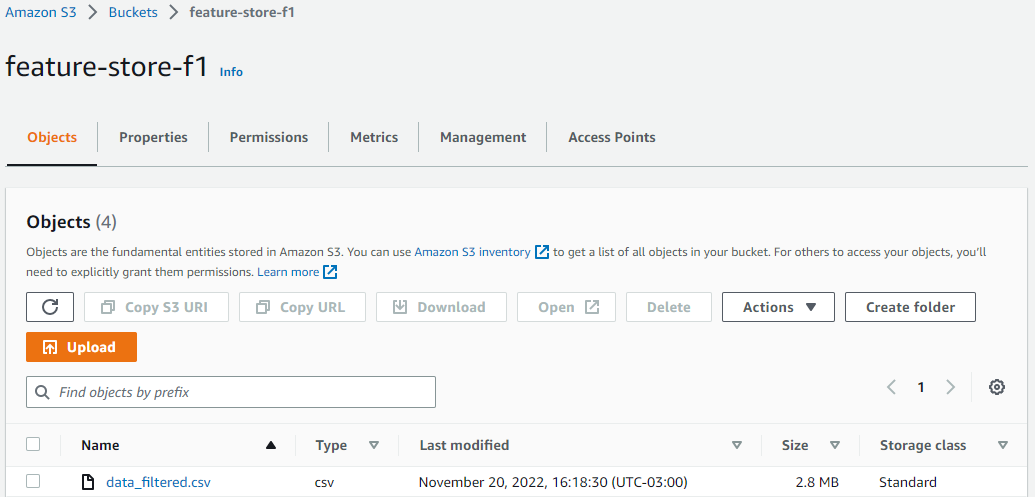

<a id="subsection_3_4"></a>
## 3.4 Análise exploratória do dados (EDA)
Além da análise inicial padrão realizada no início da seção, também foi analisado a confiabilidade dos pilotos e equipes. A confiabilidade da equipe é medida pela média das vezes que alguns de seus pilotos terminaram as provas sem falhas mecânicas, elétricas ou de erros no pit stop e a confiabilidade dos pilotos é medida pela médias de vezes que eles terminaram a prova sem se envolver em acidentes e incidentes.

In [170]:
from asynchat import async_chat
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

bucket = 'feature-store-f1'
data_key = 'data_filtered.csv'
data_location = 's3://{}/{}'.format(bucket, data_key) #s3://feature-store-f1/data_filtered.csv
df = pd.read_csv(data_location)
df.head(2)

,year,date,quali_pos,position,points,statusId,dob,driver_nationality,constructor,constructor_nationality,...,age_at_gp_in_days,driver_home,constructor_home,driver_dnf,constructor_dnf,weather_warm,weather_cold,weather_dry,weather_wet,weather_cloudy
0,1950,1950-05-13,1,1.0,9.0,1,1906-10-30,Ita,Alfa Romeo,Swi,...,15901.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,1951,1951-07-14,3,NaN,1.0,11,1906-10-30,Ita,Alfa Romeo,Swi,...,16328.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0


A seguir iremo analisar a confiabilidade das equipes e pilotos do século atual (dados de 2000 a 2022). A confiabilidade da equipe é medida pela média das vezes que alguns de seus pilotos terminaram as provas sem falhas mecânicas e a confiabilidade dos pilotos é medida pela médias de vezes que eles terminaram a prova sem se envolver em acidentes e incidentes.

In [171]:
constructor_reliability=df[['year','constructor','constructor_dnf']]
d1 = (df.loc[(df['constructor_dnf']==1) & (df['year']>1999)].groupby('constructor').count()['constructor_dnf'])
dr = pd.merge(pd.DataFrame(d1.index,columns=['constructor']),pd.DataFrame(d1.values,columns=['constructor_dnf']),left_index=True, right_index=True)

d2= (df.loc[(df['year']>1999)].groupby('constructor').count()['constructor_dnf']).fillna(0)

d2= pd.merge(pd.DataFrame(d2.index,columns=['constructor']),pd.DataFrame(d2.values,columns=['constructor_dnf']),left_index=True, right_index=True)
d2.rename(columns={'constructor_dnf':'total'},inplace=True)
constructor_reliability=pd.merge(dr,d2,how='inner',on='constructor')
constructor_reliability['ratio'] = 1 - constructor_reliability['constructor_dnf']/constructor_reliability['total']
constructor_reliability=constructor_reliability[constructor_reliability['constructor_dnf']>10]
constructor_reliability.sort_values('ratio', ascending=False)

,constructor,constructor_dnf,total,ratio
21,Mercedes,54,496,0.891129
10,Ferrari,116,840,0.861905
24,Red Bull,146,664,0.780120
6,BMW Sauber,37,132,0.719697
20,McLaren,288,840,0.657143
4,Aston Martin,230,562,0.590747
2,Alpine F1,312,760,0.589474
30,Williams,384,831,0.537906
1,AlphaTauri,331,628,0.472930
28,Toyota,141,264,0.465909


Olhando para a confiabilidade das equipes, vemos as duas equipes de F1 mais bem-sucedidas de todos os tempos no topo com a menor porcentagem de erros em relação às corridas que participou. A consistência combinada da Mercedes e de seus pilotos Lewis Hamilton, Nico Rosberg e Valtteri Bottas, conseguiu primeiro lugar no Campeonato de Construtores nas últimas 8 temporadas (2014-2021). Já a Ferrari conseguiu 7 primeiros lugares no século atual (2000, 2001, 2002, 2003, 2004, 2007 e 2008). A Red Bull que está em 3 lugar vem atrás com 4 campeonatos mundiais e brigando para ser campeão em 2022.

In [172]:
#Confiabilidade dos Pilotos
driver_reliability=df[['year','driver','driver_dnf']]
dnf_by_driver = (df.loc[(df['driver_dnf']==1) & (df['year']>1999)].groupby('driver').count()['driver_dnf'])
dnf_by_driver = pd.merge(pd.DataFrame(dnf_by_driver.index,columns=['driver']),pd.DataFrame(dnf_by_driver.values,columns=['driver_dnf']),left_index=True, right_index=True)

d2= (df.loc[(df['year']>1999)].groupby('driver').count()['driver_dnf']).fillna(0)

d2= pd.merge(pd.DataFrame(d2.index,columns=['driver']),pd.DataFrame(d2.values,columns=['driver_dnf']),left_index=True, right_index=True)
d2.rename(columns={'driver_dnf':'total'},inplace=True)

driver_reliability=pd.merge(dnf_by_driver,d2,how='inner',on='driver')
driver_reliability['ratio'] = 1 - driver_reliability['driver_dnf']/driver_reliability['total']
driver_reliability=driver_reliability[driver_reliability['driver_dnf']>10]
driver_reliability.sort_values('ratio', ascending=False)

,driver,driver_dnf,total,ratio
16,Daniel Ricciardo,11,224,0.950893
55,Lewis Hamilton,17,297,0.942761
86,Rubens Barrichello,12,205,0.941463
25,Fernando Alonso,20,340,0.941176
91,Sergio Pérez,14,228,0.938596
69,Nico Rosberg,12,192,0.937500
52,Kimi Räikkönen,24,344,0.930233
89,Sebastian Vettel,21,286,0.926573
59,Mark Webber,16,199,0.919598
23,Felipe Massa,22,258,0.914729


Em relação confiabilidade dos pilotos no último século, temos em destaque o piloto Daniel Ricciardo que aparece com um dos pilotos mais confiaveis, embora não tenha sido campeão mundial. Logo abaixo, sem surpresa, podemos ver o hepta campeão mundial Lewis Hamilton, bem conhecido por seu estilo de direção consciente do risco, minimizando o potencial de qualquer perigo de sua posição ou vitória potencial. Isso, combinado com confiabilidade da equipe, permitiu que ele tivesse um bom desempenho em pista molhada (analisado mais abaixo).

Nas posições abaixo de Lewis Hamilton, vemos vários outros campeões mundiais, incluindo Fernando Alonso, Kimi Räikkönen, Nico Rosberg e Sebastian Vettel. Na parte inferior podemos ver muitos nomes famosos da Fórmula 1 como Pastor Maldonado. Curiosamente, existem alguns nomes que são deslocados de acordo com esta regra. Max Verstappen, o piloto estrela da equipe Red Bull Racing e campeão mundial, mostra um número comparativamente alto de erros. Isso pode ser explicado por seus primeiros anos na F1, quando correu pela Renault em 2015 e depois se mudou para a Red Bull em 2016. 

Espera-se que os pilotos cometam mais erros durante os primeiros anos de sua carreira, enquanto eles aprende a controlar o temperamento, gerenciar a pressão e tornar-se mais atentos em situações que podem causar danos ao carro. O outro, Jenson Button, é altamente intrigante, pois durante o tempo analisado ele estaria nos últimos anos de sua carreira na F1 (correu até 2017), após seu título de campeão mundial em 2009. Tal resultado poderia ser explicado pelos vários anos correndo com carros não competitivos e infortúnios após 2009 combinado com o declínio na motivação para competir, levou-o a mais erros ao volante.

Como sequência, vamos analisar mais sobre os Pilotos e seus desempenhos.
- Avaliar relação de pilotos e pódios
- Relação da idade com diferentes parâmetros
- Relação entre posição de largada e de chegada
- Performance comparada com dados de Circuitos e climáticos

#### Relação de pilotos e pódios

In [173]:
# Vamos considerar um esquema de pontuação único, independente das regras em vigor no ano da corrida.
def points(pos):
    if pos==1: return 25
    elif pos==2: return 18
    elif pos==3: return 15
    elif pos==4: return 12
    elif pos==5: return 10
    elif pos==6: return 8
    elif pos==7: return 6
    elif pos==8: return 4
    elif pos==9: return 2
    elif pos==10: return 1
    else: return 0

df['points'] = df['position'].apply(points)
dfpoints = df.groupby('driver').sum('points').sort_values(by='points', ascending=False)
dfpoints.loc[:,'points']

driver
Lewis Hamilton        4598
Michael Schumacher    3853
Sebastian Vettel      3074
Fernando Alonso       2746
Kimi Räikkönen        2718
                      ... 
Jack Aitken              0
Jac Nelleman             0
Ian Stewart              0
Ian Raby                 0
Jo Vonlanthen            0
Name: points, Length: 833, dtype: int64

In [399]:
#Classificar os pilotos que conseguiram o podio (1 a 3), que pontuaram (4 a 10) e que não pontuaram (>10 ou não terminaram)
def position_index(x):
    if x<4:
        return 3
    elif x>10 or np.isnan(x):
        return 1
    else :
        return 2
    
df['position_index'] = df['position'].apply(position_index)
df[['driver', 'position_index','year']]

,driver,position_index,year
0,Nino Farina,3,1950
1,Nino Farina,1,1951
2,Luigi Fagioli,3,1950
3,Reg Parnell,3,1950
4,Juan Fangio,1,1950
...,...,...,...
25362,John Surtees,1,1960
25363,Jim Clark,1,1960
25364,Jim Hall,2,1960
25365,Pete Lovely,1,1960


#### Relação da idade e pontuação dos pilotos

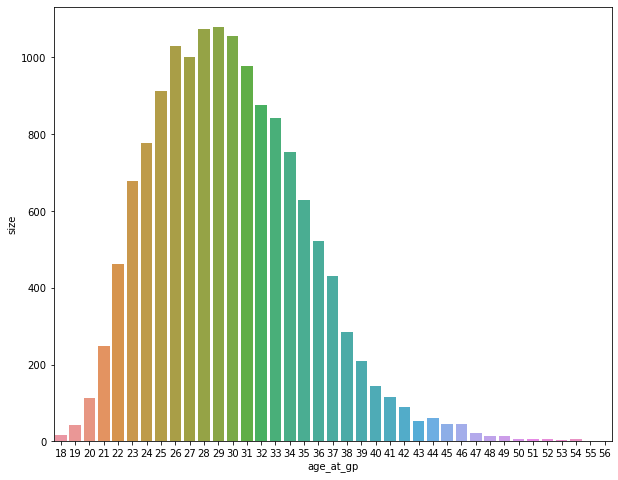

In [178]:
#Idade dos pilotos
df_ = df.dropna() 

df_['points'] = df_['position'].apply(points)
df_age = df_[['driver','age_at_gp_in_days','position_index','driver_dnf','points']]
df_age['age_at_gp']=df_age.age_at_gp_in_days.apply(lambda x: round(x/365))
#df_age_points = df_age[df_age['position_index']<3]
df_age_count =  df_age.groupby('age_at_gp', as_index=False)['points'].size()
plt.figure(figsize=(10, 8))
sns.barplot(data=df_age_count, x='age_at_gp', y='size')
display()

Pelo gráfico acima podemos notar um grande volume de pilotos jovens e que começa a diminuir a partir dos 28-29 anos. Com tantos pilotos malsucedidos sendo eliminados de equipes antes dessa idade, é compreensível que a média de posições nas pontuações para essas idades é substancialmente menor. A partir dos 28 anos, a média sobe rapidamente, já que o volume de pilotos que chegam à Fórmula 1 nesta etapa se consolida em uma boa equipe devido ao forte desempenho e consistência. Por volta da casa dos 31 anos, as médias estão, sem surpresa, começando a cair, já que as equipes colocam pilotos mais jovens enquanto olham para o futuro das equipes e os pilotos estão começando a perder sua vantagem. Existem, no entanto, algumas exceções - por exemplo, a altíssima média de pontuação para pilotos de 38 anos, alcançada por Kimi Räikkönen.

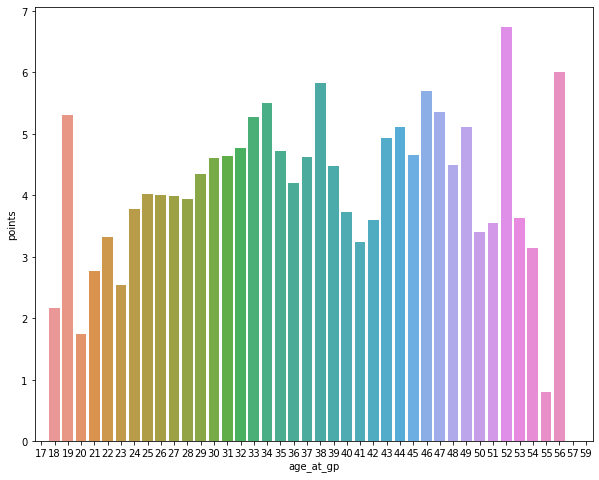

In [10]:
#Idade que mais pontua
df_age_points =  df_age.groupby('age_at_gp', as_index=False)['points'].mean()
plt.figure(figsize=(10, 8))
sns.barplot(data=df_age_points, x='age_at_gp', y='points')
display()

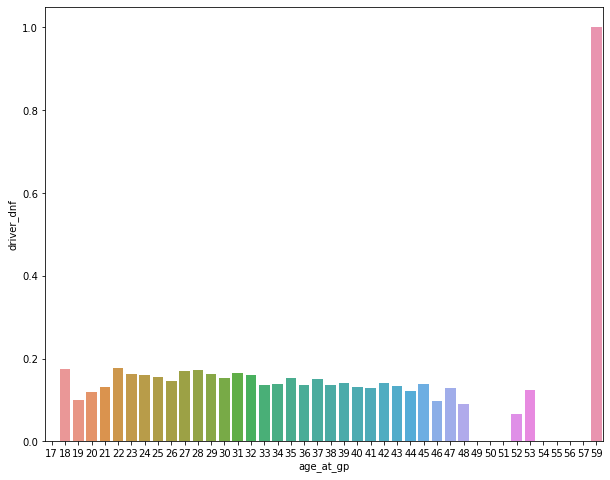

In [11]:
#Idade que menos termina as provas
df_conf = df_age[df_age['driver_dnf']==1].drop(columns=['driver','age_at_gp_in_days','position_index','points'])
#df_conf.groupby('age_at_gp', as_index=False).size()['size']
df_conf =df_age.groupby('age_at_gp', as_index=False)['driver_dnf'].mean()
plt.figure(figsize=(10, 8))
sns.barplot(data=df_conf, x='age_at_gp', y='driver_dnf')
display()

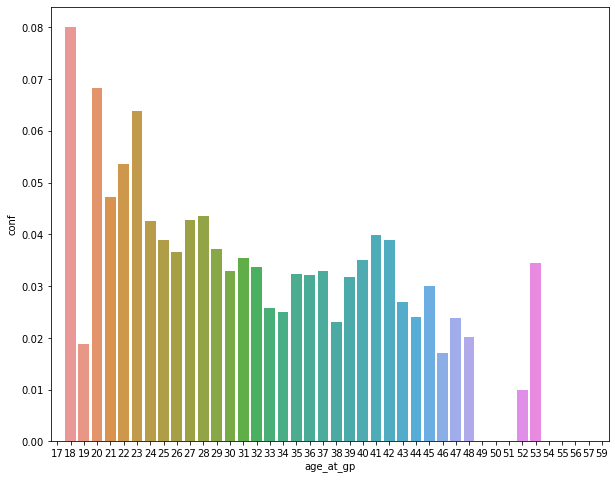

In [12]:
#Idade que não termina a corrida em relação a pontuação
df_conf['conf']=df_conf['driver_dnf']/df_age_points['points']
plt.figure(figsize=(10, 8))
sns.barplot(data=df_conf, x='age_at_gp', y='conf')
display()

Podemos entender que idade é um fator determinante para muitas decisões tomadas pelas equipes. Apesar da maioria dos pilotos possuirem 28 anos, não são estes que mais pontuam (e está longe de ser ao olharmos a base hitórica). De maneira geral, podemos ver que pilotos mais jovens podem ser perspicazes e habilidosos, mas também imprudentes e emocionais. Chega um momento em que os benefícios da juventude e da experiência atingem um equilíbrio - as reações juvenis dos motoristas são atendidas pela confiabilidade e maturidade. Aqui, os pilotos têm mais chances de vencer corridas e também de aparecer como candidatos atraentes para as equipes que procuram seu próximo grande investimento em um piloto. 

Se uma das equipes de primeira linha estiver procurando por seu próximo piloto para ajudar a lutar por um campeonato mundial, alguns anos de experiência, habilidades juvenis, e também compostura para garantir consistência, este seria o candidato ideal (que pode está nos canditados de 38 anos).

#### Relação entre posição de largada e de chegada
Pode-se perceber que a chance de vitória e pontuação está ligada com a posição de largada. A posição de largada é um dos principais atribudos para se alcançar exito em uma corrida. Quanto mais longe das primeiras posições, mais dificil é do piloto chegar em primeiro lugar. Percebe-se que quase 80% dos pilotos que chegaram em primeiro lugar largaram até da 4a posição (Considerando valores NaN, ou seja, pilotos que iniciaram mas não finalizaram as corridas).

In [55]:
#Posição que largou em relação a vitória
df_pos =  df[['quali_pos','position']]
#df_pos = df_pos[df_pos['position']==1]
#df_pos.groupby('quali_pos')['position'].size()
#df_pos

In [57]:
df_pareto = df_pos[['quali_pos','position']].copy()
df_pareto.head(5)

,quali_pos,position
0,1,1.0
1,3,NaN
2,2,2.0
3,4,3.0
4,3,NaN


In [58]:
import pandas as pd
import numpy as np

#Removendo linhas com valores NaN
df_pareto_ = df_pareto[~np.isnan(df_pareto).any(axis=1)]
df_pareto_ = df_pareto_.sort_values(by="position", ascending=False)
df_pareto_["Percent"] = df_pareto_["position"]/df["position"].sum() * 100
df_pareto_["CumPercent"] = df_pareto_["Percent"].cumsum()
df_pareto_

,quali_pos,position,Percent,CumPercent
24847,5,30.0,0.025292,0.025292
24828,32,29.0,0.024449,0.049741
24668,20,28.0,0.023606,0.073347
24824,13,27.0,0.022763,0.096110
24742,29,26.0,0.021920,0.118030
...,...,...,...,...
4138,14,1.0,0.000843,99.996628
19255,2,1.0,0.000843,99.997471
19254,3,1.0,0.000843,99.998314
19246,1,1.0,0.000843,99.999157


In [62]:
group = df_pareto_.groupby('quali_pos')['position'].size()
print(group)
print('Percentil 80:', np.percentile(group, 80))

quali_pos
0      36
1     828
2     807
3     784
4     759
5     725
6     711
7     719
8     707
9     705
10    660
11    669
12    658
13    652
14    639
15    631
16    626
17    597
18    573
19    568
20    521
21    336
22    330
23    212
24    200
25    133
26     97
27     14
28     14
29     10
30      4
31      9
32     11
33      8
Name: position, dtype: int64
Percentil 80: 708.6


In [63]:
#Calcular Percentil considerando valores NaN
group_ = df_pareto.groupby('quali_pos')['position'].size()
print(group_)
print('Percentil 80:', np.percentile(group_, 80))

quali_pos
0     1253
1     1088
2     1077
3     1082
4     1079
5     1083
6     1077
7     1084
8     1079
9     1083
10    1079
11    1082
12    1078
13    1075
14    1073
15    1063
16    1050
17    1038
18    1001
19     990
20     947
21     695
22     655
23     448
24     427
25     298
26     241
27      42
28      26
29      19
30      14
31      16
32      15
33       9
34       1
Name: position, dtype: int64
Percentil 80: 1079.6000000000001



Pela tabela de correlação abaixo, podemos notar a forte correlação entre a posição de largada e chegada ('quali_pos' e 'position').

In [39]:
df.corr()

,year,quali_pos,position,statusId,age_at_gp_in_days,driver_home,constructor_home,driver_dnf,constructor_dnf,weather_warm,weather_cold,weather_dry,weather_wet,weather_cloudy,position_index,points
year,1.000000,-0.005161,0.200741,-0.101235,-0.341364,-0.198966,-0.184848,-0.046998,-0.196118,0.093932,-0.044565,-0.221861,-0.003107,0.191271,-0.046993,0.027668
quali_pos,-0.005161,1.000000,0.643911,-0.028705,-0.059865,0.053139,0.044337,-0.111270,0.396737,0.015406,0.009954,-0.001680,-0.004460,-0.016369,0.370035,-0.427682
position,0.200741,0.643911,1.000000,0.357606,-0.153126,0.016765,0.003681,0.119513,0.565813,0.018333,-0.020339,-0.071843,0.016292,0.037326,0.901411,-0.885210
statusId,-0.101235,-0.028705,0.357606,1.000000,0.007703,0.013916,0.002415,0.301577,0.200143,-0.002959,0.025268,0.024712,-0.002561,-0.025136,0.443926,-0.395781
age_at_gp_in_days,-0.341364,-0.059865,-0.153126,0.007703,1.000000,0.080698,0.069657,-0.023501,0.034551,-0.017621,0.011538,0.070096,0.003045,-0.061567,-0.056874,0.067429
driver_home,-0.198966,0.053139,0.016765,0.013916,0.080698,1.000000,0.392342,0.007839,0.019994,-0.007813,0.008309,0.014543,-0.005564,-0.035090,0.025912,-0.022201
constructor_home,-0.184848,0.044337,0.003681,0.002415,0.069657,0.392342,1.000000,-0.014103,0.023619,-0.015635,0.001545,0.013698,-0.012808,-0.039840,0.006479,-0.000206
driver_dnf,-0.046998,-0.111270,0.119513,0.301577,-0.023501,0.007839,-0.014103,1.000000,-0.488317,-0.004298,0.061811,0.013065,0.067710,-0.012288,0.317531,-0.262250
constructor_dnf,-0.196118,0.396737,0.565813,0.200143,0.034551,0.019994,0.023619,-0.488317,1.000000,-0.006305,-0.014216,0.041079,-0.053908,-0.053712,0.405376,-0.453384
weather_warm,0.093932,0.015406,0.018333,-0.002959,-0.017621,-0.007813,-0.015635,-0.004298,-0.006305,1.000000,-0.094196,-0.301090,-0.231757,-0.150424,0.003629,-0.004306


Também foi analisado outras questões sem muita relevancia para o resultado final, como os motivos do piloto não finalizar a corrida, e os pilotos que mais tiveram problema ou  que mais pontuaram em corridas chuvosas.

#### Performance comparada com dados de Circuitos e climáticos

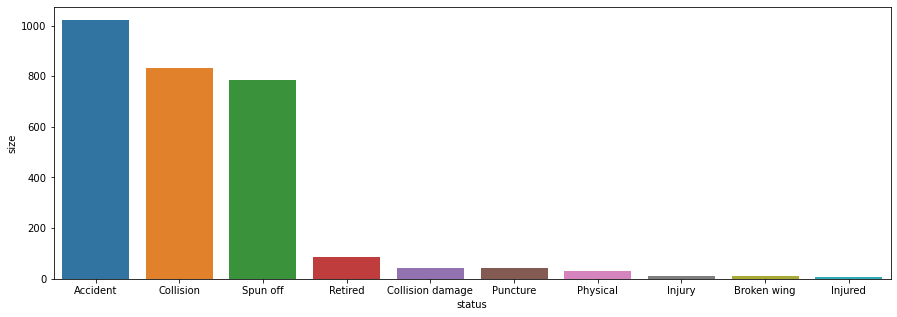

In [93]:
#Motivos do piloto não finalizar a corrida por Circuito
df_circ_dnf=df[['statusId','GP_name','driver_dnf']]
df_circ_dnf=df_circ_dnf[(df_circ_dnf['driver_dnf']==1)]
df_circ_dnf=df_circ_dnf[(df_circ_dnf['statusId']!=60)]
df_circ_dnf=df_circ_dnf[(df_circ_dnf['statusId']!=84)]
df_status=pd.read_csv('./datasets/status.csv')
df_circ_dnf = pd.merge(df_circ_dnf,df_status,on=['statusId'],how='inner')
df_circ_status = df_circ_dnf.groupby(['GP_name'], as_index=False).size()
df_circ_status.sort_values('size', ascending=False)
df_status_top = df_circ_dnf.groupby(['statusId','status'], as_index=False).size()
df_status_top = df_status_top.sort_values('size', ascending=False)
#df_status_top
# df_circ_dnf= df_circ_dnf.groupby(['GP_name','statusId','status'], as_index=False).size().sort_values('GP_name')
# df_circ_dnf
#Por tipo de problema
plt.figure(figsize=(15, 5))
sns.barplot(data=df_status_top.head(10),x='status',y='size')
display()
#Spun off - Derrapa

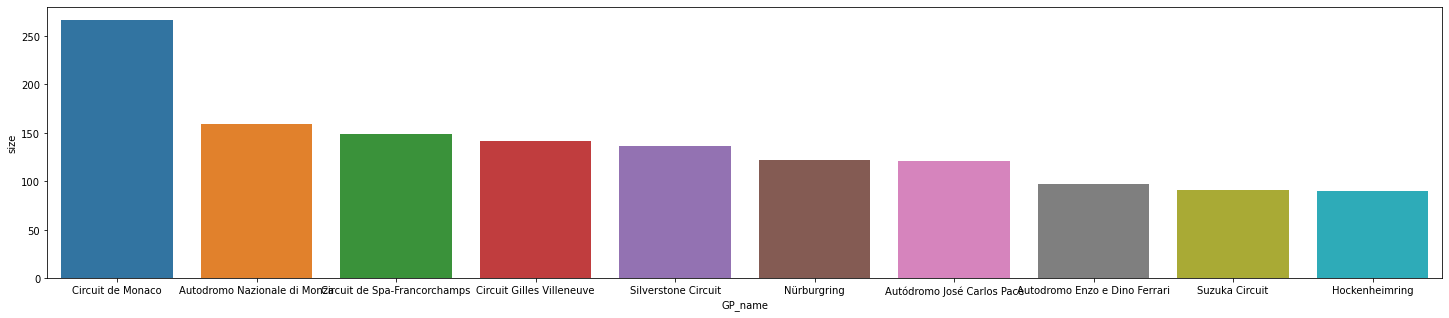

In [94]:
#Por circuito
plt.figure(figsize=(25, 5))
sns.barplot(data=df_circ_status.sort_values('size', ascending=False).head(10),x='GP_name',y='size')
display()

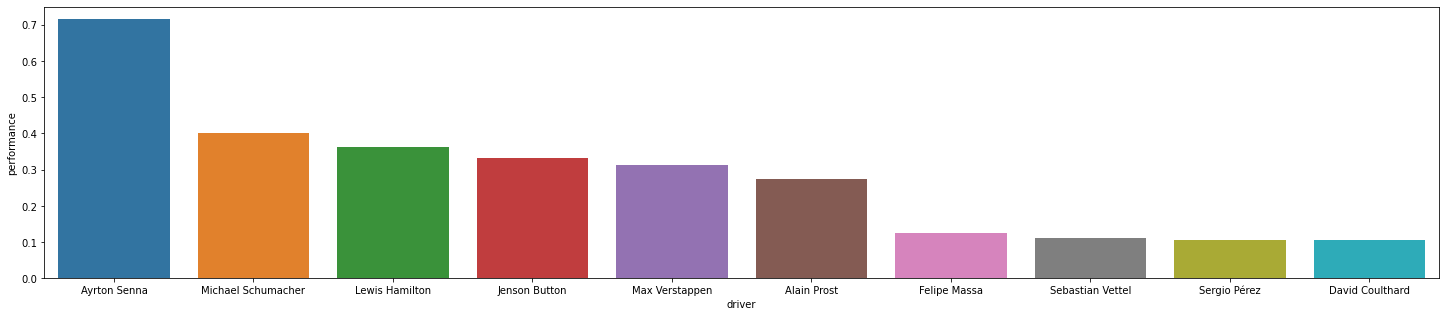

In [3]:
#Pilotos com maiores vitorias na chuva
df_driver_wet = df[['driver','weather_wet','position']]
df_driver_wet = df_driver_wet[(df_driver_wet['weather_wet']==1)&(df_driver_wet['position']<11)]
df_driver_first_wet = df_driver_wet[(df_driver_wet['weather_wet']==1)&(df_driver_wet['position']==1)]
df_driver_first_wet = df_driver_first_wet.groupby('driver',as_index=False )['position'].size()
df_driver_wet = df_driver_wet.groupby('driver',as_index=False )['position'].size()
df_driver_wet.rename(columns = {'size': 'total'}, inplace = True)
df_driver_wet = df_driver_wet[df_driver_wet['total']>10]
df_driver_wet = pd.merge(df_driver_wet, df_driver_first_wet,on=['driver'])
df_driver_wet['performance'] = df_driver_wet['size']/df_driver_wet['total']
# df_driver_wet = pd.merge(df_driver_race_wet,df_driver_points_wet, on=['driver'])
#
# df_driver_wet['wet'] = df_driver_wet['points']/df_driver_wet['size']
df_driver_wet.sort_values('performance',ascending=False)
# df_driver_wet.sort_values('wet', ascending=False)
plt.figure(figsize=(25, 5))
sns.barplot(data=df_driver_wet.sort_values('performance', ascending=False).head(10),x='driver',y='performance')
display()

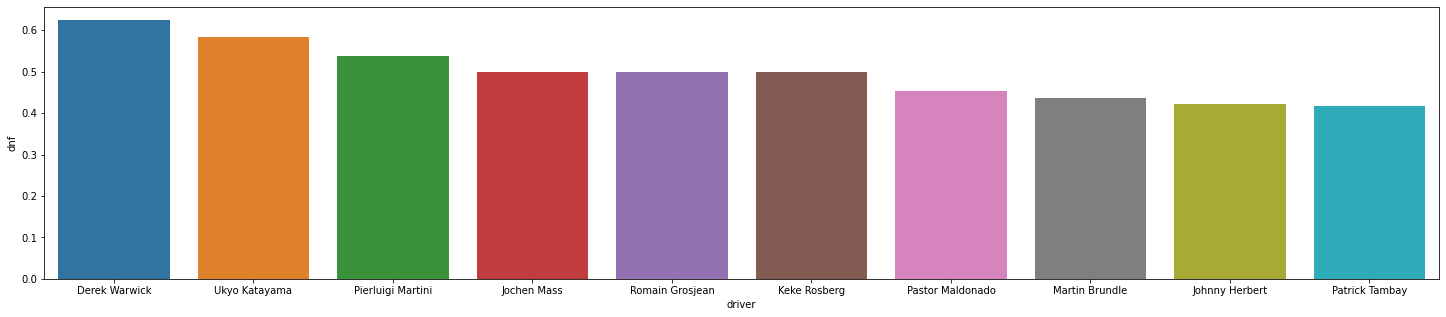

In [64]:
#Pilotos com maiores índices de não finalizar corrida (dnf) na chuva
df_driver_wet = df[['driver','weather_wet','driver_dnf']]
df_driver_wet = df_driver_wet[(df_driver_wet['weather_wet']==1)]
df_driver_dnf_wet = df_driver_wet[(df_driver_wet['weather_wet']==1)&(df_driver_wet['driver_dnf']==1)]
df_driver_dnf_wet = df_driver_dnf_wet.groupby('driver',as_index=False )['driver_dnf'].size()
df_driver_wet = df_driver_wet.groupby('driver',as_index=False )['driver_dnf'].size()
df_driver_wet.rename(columns = {'size': 'total'}, inplace = True)
df_driver_wet = df_driver_wet[df_driver_wet['total']>10]
df_driver_wet = pd.merge(df_driver_wet, df_driver_dnf_wet,on=['driver'])
df_driver_wet['dnf'] = df_driver_wet['size']/df_driver_wet['total']
# df_driver_wet = pd.merge(df_driver_race_wet,df_driver_points_wet, on=['driver'])
#
# df_driver_wet['wet'] = df_driver_wet['points']/df_driver_wet['size']
df_driver_wet.sort_values('dnf',ascending=False)
# df_driver_wet.sort_values('wet', ascending=False)
plt.figure(figsize=(25, 5))
sns.barplot(data=df_driver_wet.sort_values('dnf', ascending=False).head(10),x='driver',y='dnf')
display()

<a id="section_4"></a> 
# 4. Desenvolvimento do modelo

----
Nesta fase, selecionamos {um algoritmo de aprendizado de máquina} por ser mais apropriado para o problema e, em seguida, foi relizado o treino do modelo de ML. Os dados de treino foram retirados da Feature Store ("nome"), a métrica {xxxx} objetiva para otimizar o modelo de ML e foram utilizados os hiperparâmetros {x, y e z} para otimizar o processo de treinamento.

<a id="subsection_4_1"></a> 
## 4.1 Treinamento do modelo


In [208]:
#Busca dataset na Feature Store
from asynchat import async_chat
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

bucket = 'feature-store-f1'
data_key = 'data_filtered.csv'
data_location = 's3://{}/{}'.format(bucket, data_key) #s3://feature-store-f1/data_filtered.csv
df = pd.read_csv(data_location)
df

,year,date,quali_pos,position,points,statusId,dob,driver_nationality,constructor,constructor_nationality,...,age_at_gp_in_days,driver_home,constructor_home,driver_dnf,constructor_dnf,weather_warm,weather_cold,weather_dry,weather_wet,weather_cloudy
0,1950,1950-05-13,1,1.0,9.0,1,1906-10-30,Ita,Alfa Romeo,Swi,...,15901.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,1951,1951-07-14,3,NaN,1.0,11,1906-10-30,Ita,Alfa Romeo,Swi,...,16328.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0
2,1950,1950-05-13,2,2.0,6.0,1,1898-06-09,Ita,Alfa Romeo,Swi,...,18965.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,1950,1950-05-13,4,3.0,4.0,1,1911-07-02,Bri,Alfa Romeo,Swi,...,14195.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,1950,1950-05-13,3,NaN,0.0,6,1911-06-24,Arg,Alfa Romeo,Swi,...,14203.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
24939,2003,2003-09-28,5,NaN,0.0,17,1975-06-30,Ger,Williams,Bri,...,10317.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0
24940,2004,2004-06-20,6,NaN,0.0,68,1975-06-30,Ger,Williams,Bri,...,10583.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0
24941,2007,2007-06-17,17,10.0,0.0,15,1974-02-15,Aus,Williams,Bri,...,12175.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0
24942,2005,2005-06-19,15,NaN,0.0,39,1977-05-10,Ger,Williams,Bri,...,10267.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0


In [209]:
#Inserir a confiabilidade do piloto
#Confiabilidade dos Pilotos
df = pd.read_csv('./datasets/data_filtered.csv')
dnf_by_driver = df.groupby('driver').sum()['driver_dnf']
driver_race_entered = df.groupby('driver').count()['driver_dnf']
driver_dnf_ratio = (dnf_by_driver/driver_race_entered)
driver_reliability = 1-driver_dnf_ratio
driver_reliability = dict(zip(driver_reliability.index,driver_reliability))
df['driver_confidence'] = df['driver'].apply(lambda x:driver_reliability[x])
df

,year,date,quali_pos,position,points,statusId,dob,driver_nationality,constructor,constructor_nationality,...,driver_home,constructor_home,driver_dnf,constructor_dnf,weather_warm,weather_cold,weather_dry,weather_wet,weather_cloudy,driver_confidence
0,1950,1950-05-13,1,1.0,9.0,1,1906-10-30,Ita,Alfa Romeo,Swi,...,0,0,0,0,0,0,0,0,0,0.945946
1,1951,1951-07-14,3,NaN,1.0,11,1906-10-30,Ita,Alfa Romeo,Swi,...,0,0,0,1,0,0,1,0,0,0.945946
2,1950,1950-05-13,2,2.0,6.0,1,1898-06-09,Ita,Alfa Romeo,Swi,...,0,0,0,0,0,0,0,0,0,0.875000
3,1950,1950-05-13,4,3.0,4.0,1,1911-07-02,Bri,Alfa Romeo,Swi,...,1,0,0,0,0,0,0,0,0,1.000000
4,1950,1950-05-13,3,NaN,0.0,6,1911-06-24,Arg,Alfa Romeo,Swi,...,0,0,0,1,0,0,0,0,0,0.982759
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
25362,1960,1960-11-20,6,NaN,0.0,17,1934-02-11,Bri,Team Lotus,Bri,...,0,0,1,0,0,0,0,0,0,0.955357
25363,1960,1960-11-20,5,16.0,0.0,56,1936-03-04,Bri,Team Lotus,Bri,...,0,0,0,1,0,0,0,0,0,0.972603
25364,1960,1960-11-20,12,7.0,0.0,15,1935-07-23,Ame,Team Lotus,Bri,...,1,0,0,1,0,0,0,0,0,0.916667
25365,1960,1960-11-20,20,11.0,0.0,5,1926-04-11,Ame,Cooper-Castellotti,Bri,...,1,0,0,1,0,0,0,0,0,0.636364


In [210]:
dnf_by_constructor = df.groupby('constructor').sum()['constructor_dnf']
constructor_race_entered = df.groupby('constructor').count()['constructor_dnf']
constructor_dnf_ratio = (dnf_by_constructor/constructor_race_entered)
constructor_reliability = 1-constructor_dnf_ratio
constructor_reliability = dict(zip(constructor_reliability.index,constructor_reliability))
constructor_reliability
df['constructor_confidence'] = df['constructor'].apply(lambda x:constructor_reliability[x])
df

,year,date,quali_pos,position,points,statusId,dob,driver_nationality,constructor,constructor_nationality,...,constructor_home,driver_dnf,constructor_dnf,weather_warm,weather_cold,weather_dry,weather_wet,weather_cloudy,driver_confidence,constructor_confidence
0,1950,1950-05-13,1,1.0,9.0,1,1906-10-30,Ita,Alfa Romeo,Swi,...,0,0,0,0,0,0,0,0,0.945946,0.381072
1,1951,1951-07-14,3,NaN,1.0,11,1906-10-30,Ita,Alfa Romeo,Swi,...,0,0,1,0,0,1,0,0,0.945946,0.381072
2,1950,1950-05-13,2,2.0,6.0,1,1898-06-09,Ita,Alfa Romeo,Swi,...,0,0,0,0,0,0,0,0,0.875000,0.381072
3,1950,1950-05-13,4,3.0,4.0,1,1911-07-02,Bri,Alfa Romeo,Swi,...,0,0,0,0,0,0,0,0,1.000000,0.381072
4,1950,1950-05-13,3,NaN,0.0,6,1911-06-24,Arg,Alfa Romeo,Swi,...,0,0,1,0,0,0,0,0,0.982759,0.381072
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
25362,1960,1960-11-20,6,NaN,0.0,17,1934-02-11,Bri,Team Lotus,Bri,...,0,1,0,0,0,0,0,0,0.955357,0.383199
25363,1960,1960-11-20,5,16.0,0.0,56,1936-03-04,Bri,Team Lotus,Bri,...,0,0,1,0,0,0,0,0,0.972603,0.383199
25364,1960,1960-11-20,12,7.0,0.0,15,1935-07-23,Ame,Team Lotus,Bri,...,0,0,1,0,0,0,0,0,0.916667,0.383199
25365,1960,1960-11-20,20,11.0,0.0,5,1926-04-11,Ame,Cooper-Castellotti,Bri,...,0,0,1,0,0,0,0,0,0.636364,0.166667


In [113]:
# #Guardando nova tabela na Feature Store

# #Formato .CSV
# df.to_csv('./datasets/data_toproc.csv',index=False)

# #S3
# bucket = 'feature-store-f1'
# data_key = 'data_toproc.csv'
# data_location = 's3://{}/{}'.format(bucket, data_key) #s3://feature-store-f1/data_toproc.csv
# df = pd.read_csv(data_location)
# #df

In [211]:
df_parc = df[['year','GP_name','quali_pos','driver','points','age_at_gp_in_days','position','driver_confidence','constructor','constructor_confidence','weather_warm','weather_cold','weather_dry','weather_wet','weather_cloudy']]
#df_parc = df[['year','GP_name','quali_pos','driver','age_at_gp_in_days','position','driver_confidence','active_driver']]

In [212]:
#Pilotos atuais
df2022 = df_parc[df_parc['year']==2022]
df_parc['active_driver'] = df_parc['driver'].apply(lambda x: int(x in df2022['driver'].unique()))
df_parc['active_constructor'] = df_parc['constructor'].apply(lambda x: int(x in df2022['constructor'].unique()))
df_parc

,year,GP_name,quali_pos,driver,points,age_at_gp_in_days,position,driver_confidence,constructor,constructor_confidence,weather_warm,weather_cold,weather_dry,weather_wet,weather_cloudy,active_driver,active_constructor
0,1950,Silverstone Circuit,1,Nino Farina,9.0,15901,1.0,0.945946,Alfa Romeo,0.381072,0,0,0,0,0,0,1
1,1951,Silverstone Circuit,3,Nino Farina,1.0,16328,NaN,0.945946,Alfa Romeo,0.381072,0,0,1,0,0,0,1
2,1950,Silverstone Circuit,2,Luigi Fagioli,6.0,18965,2.0,0.875000,Alfa Romeo,0.381072,0,0,0,0,0,0,1
3,1950,Silverstone Circuit,4,Reg Parnell,4.0,14195,3.0,1.000000,Alfa Romeo,0.381072,0,0,0,0,0,0,1
4,1950,Silverstone Circuit,3,Juan Fangio,0.0,14203,NaN,0.982759,Alfa Romeo,0.381072,0,0,0,0,0,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
25362,1960,Riverside International Raceway,6,John Surtees,0.0,9779,NaN,0.955357,Team Lotus,0.383199,0,0,0,0,0,0,0
25363,1960,Riverside International Raceway,5,Jim Clark,0.0,9027,16.0,0.972603,Team Lotus,0.383199,0,0,0,0,0,0,0
25364,1960,Riverside International Raceway,12,Jim Hall,0.0,9252,7.0,0.916667,Team Lotus,0.383199,0,0,0,0,0,0,0
25365,1960,Riverside International Raceway,20,Pete Lovely,0.0,12642,11.0,0.636364,Cooper-Castellotti,0.166667,0,0,0,0,0,0,0


In [213]:
df_parc = df_parc[(df_parc['active_constructor']==1) & (df_parc['active_driver']==1)]
df_parc.drop(columns={'active_driver','active_constructor','points'},axis=1,inplace=True) #,'age_at_gp_in_days','weather_wet','weather_dry','weather_cold','weather_warm','weather_cloudy'},axis=1,inplace=True)

In [214]:
df_parc

,year,GP_name,quali_pos,driver,age_at_gp_in_days,position,driver_confidence,constructor,constructor_confidence,weather_warm,weather_cold,weather_dry,weather_wet,weather_cloudy
18,2022,Silverstone Circuit,12,Valtteri Bottas,11997,NaN,0.950000,Alfa Romeo,0.381072,0,0,0,0,1
23,2022,Silverstone Circuit,9,Guanyu Zhou,8435,NaN,0.904762,Alfa Romeo,0.381072,0,0,0,0,1
124,2010,Silverstone Circuit,3,Fernando Alonso,10574,14.0,0.941176,Ferrari,0.622118,1,0,0,0,0
125,2011,Silverstone Circuit,3,Fernando Alonso,10938,1.0,0.941176,Ferrari,0.622118,0,0,0,1,0
126,2012,Silverstone Circuit,1,Fernando Alonso,11302,2.0,0.941176,Ferrari,0.622118,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
25310,2012,Buddh International Circuit,1,Sebastian Vettel,9249,1.0,0.929766,Red Bull,0.776657,0,0,0,0,1
25311,2013,Buddh International Circuit,1,Sebastian Vettel,9613,1.0,0.929766,Red Bull,0.776657,0,0,0,0,1
25314,2012,Buddh International Circuit,12,Nico Hülkenberg,9202,8.0,0.902174,Aston Martin,0.587940,0,0,0,0,1
25336,2012,Buddh International Circuit,15,Daniel Ricciardo,8520,13.0,0.952381,AlphaTauri,0.475610,0,0,0,0,1


In [215]:
def position_index(x):
    if x<4:
        return 3
    if x>10:
        return 1
    else :
        return 2

##### Split dos dados em train/validation/test (~70/20/10)

In [216]:
df_tt = df_parc[df_parc['year']<=2021].copy()
df_val = df_parc[df_parc['year']==2022].copy()

df_tt.drop(columns='year', inplace=True)
df_val.drop(columns='year', inplace=True)

df_tt_c =df_tt.copy()
df_val_c = df_val.copy()

df_tt_c['position'] = df_tt_c['position'].fillna(99)

In [287]:
df_tt = df_parc[df_parc['year']<=2021].copy()
df_val = df_parc[df_parc['year']==2022].copy()

df_tt.drop(columns='year', inplace=True)
df_val.drop(columns='year', inplace=True)

df_tt_c =df_tt.copy()
df_val_c = df_val.copy()

df_tt_c['position'] = df_tt_c['position'].fillna(99)

In [217]:
from sklearn.model_selection import train_test_split
df_train, df_test, x_train, y_test = train_test_split(df_tt,df_tt['position'], test_size=0.2, random_state=42)

In [218]:
print(df_train.shape)
print(df_test.shape)
print(df_val.shape)

(2120, 13)
(531, 13)
(420, 13)


In [219]:
#Armazenando em CSV
df_tt.to_csv('./datasets/data_clean.csv', index=False)
df_train.to_csv('./datasets/data_train.csv', index=False)
df_test.to_csv('./datasets/data_test.csv', index=False)
df_val.to_csv('./datasets/data_val.csv', index=False)

In [224]:
#Armazenando em bucket (Feature Store)
import os
import boto3

bucket = 'feature-store-f1'
prefix = 'data'

# Upload - S3 bucket
s3_input_train = (boto3.Session().resource("s3").Bucket(bucket).Object(os.path.join(prefix, "train.csv")).upload_file("./datasets/data_train.csv"))
s3_input_test = (boto3.Session().resource("s3").Bucket(bucket).Object(os.path.join(prefix, "validation.csv")).upload_file("./datasets/data_test.csv"))
s3_input_validation = (boto3.Session().resource("s3").Bucket(bucket).Object(os.path.join(prefix, "test.csv")).upload_file("./datasets/data_val.csv"))

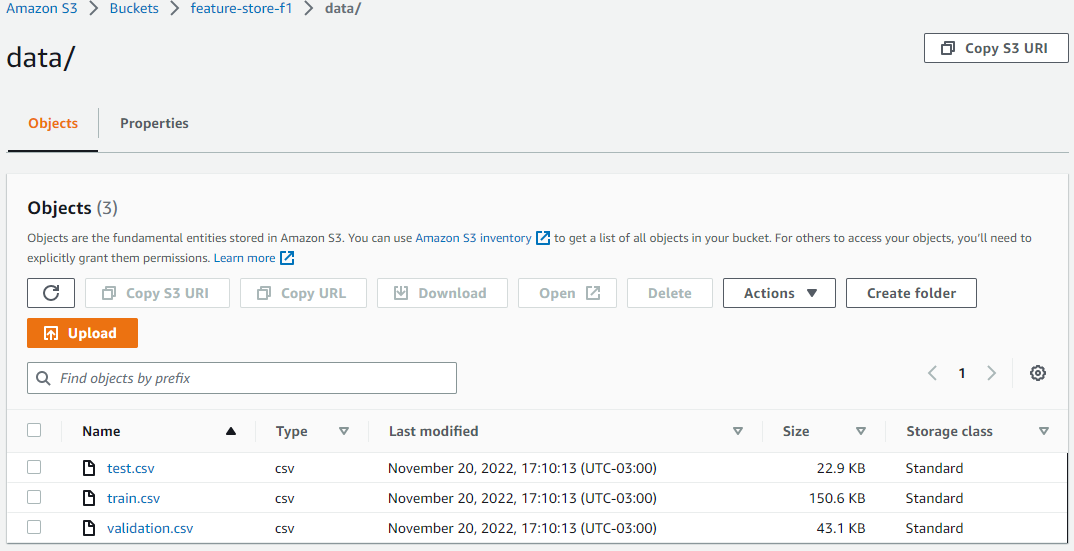

In [286]:
bucket = 'feature-store-f1' #Identificação do bucket em que o lambda armazenou os dados
data_key = 'data/train.csv'
data_location = 's3://{}/{}'.format(bucket, data_key)

# import awswrangler as wr 
df_train = wr.s3.read_csv(data_location)

print(f'**** Training set ****\n')
print(f'{df_train.info()}')
print(f'{df_train.shape}')

**** Training set ****

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2120 entries, 0 to 2119
Data columns (total 13 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   GP_name                 2120 non-null   object 
 1   quali_pos               2120 non-null   int64  
 2   driver                  2120 non-null   object 
 3   age_at_gp_in_days       2120 non-null   int64  
 4   position                1799 non-null   float64
 5   driver_confidence       2120 non-null   float64
 6   constructor             2120 non-null   object 
 7   constructor_confidence  2120 non-null   float64
 8   weather_warm            2120 non-null   int64  
 9   weather_cold            2120 non-null   int64  
 10  weather_dry             2120 non-null   int64  
 11  weather_wet             2120 non-null   int64  
 12  weather_cloudy          2120 non-null   int64  
dtypes: float64(3), int64(7), object(3)
memory usage: 215.4+ KB
None
(2120

In [264]:
bucket = 'feature-store-f1' #Identificação do bucket em que o lambda armazenou os dados
data_key = 'data/test.csv'
data_location = 's3://{}/{}'.format(bucket, data_key)

# import awswrangler as wr 
df_test = wr.s3.read_csv(data_location)

print(f'**** Training set ****\n')
print(f'{df_test.info()}')
print(f'{df_test.shape}')

**** Training set ****

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 420 entries, 0 to 419
Data columns (total 13 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   GP_name                 420 non-null    object 
 1   quali_pos               420 non-null    int64  
 2   driver                  420 non-null    object 
 3   age_at_gp_in_days       420 non-null    int64  
 4   position                357 non-null    float64
 5   driver_confidence       420 non-null    float64
 6   constructor             420 non-null    object 
 7   constructor_confidence  420 non-null    float64
 8   weather_warm            420 non-null    int64  
 9   weather_cold            420 non-null    int64  
 10  weather_dry             420 non-null    int64  
 11  weather_wet             420 non-null    int64  
 12  weather_cloudy          420 non-null    int64  
dtypes: float64(3), int64(7), object(3)
memory usage: 42.8+ KB
None
(420, 13

In [265]:
df_train.corr()

,quali_pos,age_at_gp_in_days,position,driver_confidence,constructor_confidence,weather_warm,weather_cold,weather_dry,weather_wet,weather_cloudy
quali_pos,1.000000,-0.191450,0.653673,-0.236386,-0.485842,-0.018577,0.025145,-0.045307,-0.015581,0.058056
age_at_gp_in_days,-0.191450,1.000000,-0.216672,0.313089,0.331078,-0.001457,-0.006411,-0.038313,-0.003773,0.006115
position,0.653673,-0.216672,1.000000,-0.249628,-0.540752,-0.002068,NaN,-0.046675,0.016204,0.051032
driver_confidence,-0.236386,0.313089,-0.249628,1.000000,0.228763,0.004752,0.012442,0.047220,-0.006242,-0.037681
constructor_confidence,-0.485842,0.331078,-0.540752,0.228763,1.000000,-0.007038,-0.012557,0.000500,-0.009354,-0.011063
weather_warm,-0.018577,-0.001457,-0.002068,0.004752,-0.007038,1.000000,-0.015677,-0.119325,-0.239617,-0.354619
weather_cold,0.025145,-0.006411,NaN,0.012442,-0.012557,-0.015677,1.000000,-0.007411,0.061379,-0.011117
weather_dry,-0.045307,-0.038313,-0.046675,0.047220,0.000500,-0.119325,-0.007411,1.000000,0.232617,-0.041366
weather_wet,-0.015581,-0.003773,0.016204,-0.006242,-0.009354,-0.239617,0.061379,0.232617,1.000000,0.055539
weather_cloudy,0.058056,0.006115,0.051032,-0.037681,-0.011063,-0.354619,-0.011117,-0.041366,0.055539,1.000000


In [266]:
from sklearn.preprocessing import StandardScaler,LabelEncoder
from sklearn.model_selection import cross_val_score,StratifiedKFold,RandomizedSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.dummy import DummyRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from xgboost import XGBClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.dummy import DummyClassifier
from sklearn.metrics import confusion_matrix,precision_score,f1_score,recall_score
from lightgbm import LGBMClassifier

In [310]:
from sagemaker.xgboost.estimator import XGBoost

In [311]:
sc  = StandardScaler()
le = LabelEncoder()
df_train['GP_name'] = le.fit_transform(df_train['GP_name'])
df_train['driver'] = le.fit_transform(df_train['driver'])
df_train['constructor'] = le.fit_transform(df_train['constructor'])

X_train = df_train.drop(['position'], axis=1)
y_train = df_train['position'].fillna(0).copy()
#df_train['age_at_gp_in_days'] = sc.fit_transform(df_train[['age_at_gp_in_days']])

In [268]:
#cross validation para diferentes modelos
mean_results = []
results = []
name = []
models = [DummyRegressor(strategy='median'), LogisticRegression(),DecisionTreeRegressor()]
names = ['DummyRegressor', 'LogisticRegression','DecisionTreeRegressor']
model_dict = dict(zip(models,names))
for model in models:
    cv = StratifiedKFold(n_splits=11,random_state=1,shuffle=True)
    result = cross_val_score(model,X_train,y_train,cv=cv,scoring='f1_macro')
    mean_results.append(result.mean())
    results.append(result)
    name.append(model_dict[model])
    print(f'{model_dict[model]} : {result.mean()}')

DummyRegressor : 0.006251131455962145
LogisticRegression : 0.04315635414424861
DecisionTreeRegressor : 0.09633704252607833


In [316]:
df_tt = df_parc[df_parc['year']<=2021].copy()
df_val = df_parc[df_parc['year']==2022].copy()

df_tt.drop(columns='year', inplace=True)
df_val.drop(columns='year', inplace=True)

df_tt_c =df_tt.copy()
df_val_c = df_val.copy()

df_tt_c['position'] = df_tt_c['position'].fillna(99)

In [317]:
#Reduzir o número de classe, para 3, para melhorar performance com classificadores
df_tt_c['position'] = df_tt_c['position'].apply(lambda x: position_index(x))

In [318]:
df_train_c, df_test_c = train_test_split(df_tt_c, stratify=df_tt_c['position'], test_size=0.2, random_state=42)

sc = StandardScaler()
le = LabelEncoder()
df_train_c['GP_name'] = le.fit_transform(df_train_c['GP_name'])
df_train_c['driver'] = le.fit_transform(df_train_c['driver'])
df_train_c['constructor'] = le.fit_transform(df_train_c['constructor'])
X_train_c = df_train_c.drop(['position'], axis=1)
y_train_c = df_train_c['position']

In [319]:
#cross validation para diferentes modelos
mean_results = []
results = []
name = []
models = [DummyClassifier(), SVC(), KNeighborsClassifier(),  DecisionTreeClassifier(),XGBClassifier(eval_metric='rmse'),RandomForestClassifier(), LogisticRegression(), LGBMClassifier(),GradientBoostingClassifier()]
names = ['DummyClassifier', 'SVC', 'KNeighborsClassifier', 'DecisionTreeClassifier','XGBClassifier', 'RandomForestClassifier', 'LogisticRegression','LGBMClassifier','GradientBoostingClassifier']
model_dict = dict(zip(models,names))
for model in models:
    cv = StratifiedKFold(n_splits=11,random_state=1,shuffle=True)
    result = cross_val_score(model,X_train_c,y_train_c,cv=cv,scoring='f1_macro')
    mean_results.append(result.mean())
    results.append(result)
    name.append(model_dict[model])
    print(f'{model_dict[model]} : {result.mean()}')

DummyClassifier : 0.18950988738482497
SVC : 0.31739744147109145
KNeighborsClassifier : 0.3821838822747354
DecisionTreeClassifier : 0.5437363350023048
XGBClassifier : nan
RandomForestClassifier : 0.6050820737449407
LogisticRegression : 0.6160343814530487
LGBMClassifier : 0.6241953413279961
GradientBoostingClassifier : 0.6468142053238708


In [290]:
#cross validation para diferentes modelos
mean_results = []
results = []
name = []
models = [DummyClassifier(), SVC(), KNeighborsClassifier(),  DecisionTreeClassifier(),XGBClassifier(eval_metric='rmse'),RandomForestClassifier(), LogisticRegression(), LGBMClassifier(),GradientBoostingClassifier()]
names = ['DummyClassifier', 'SVC', 'KNeighborsClassifier', 'DecisionTreeClassifier','XGBClassifier', 'RandomForestClassifier', 'LogisticRegression','LGBMClassifier','GradientBoostingClassifier']
model_dict = dict(zip(models,names))
for model in models:
    cv = StratifiedKFold(n_splits=11,random_state=1,shuffle=True)
    result = cross_val_score(model,X_train_c,y_train_c,cv=cv,scoring='f1_macro')
    mean_results.append(result.mean())
    results.append(result)
    name.append(model_dict[model])
    print(f'{model_dict[model]} : {result.mean()}')

DummyClassifier : 0.18950988738482497
SVC : 0.31739744147109145
KNeighborsClassifier : 0.3821838822747354
DecisionTreeClassifier : 0.5432546936872698
XGBClassifier : nan
RandomForestClassifier : 0.6056660696979379
LogisticRegression : 0.6160343814530487
LGBMClassifier : 0.6241953413279961
GradientBoostingClassifier : 0.647247776163476


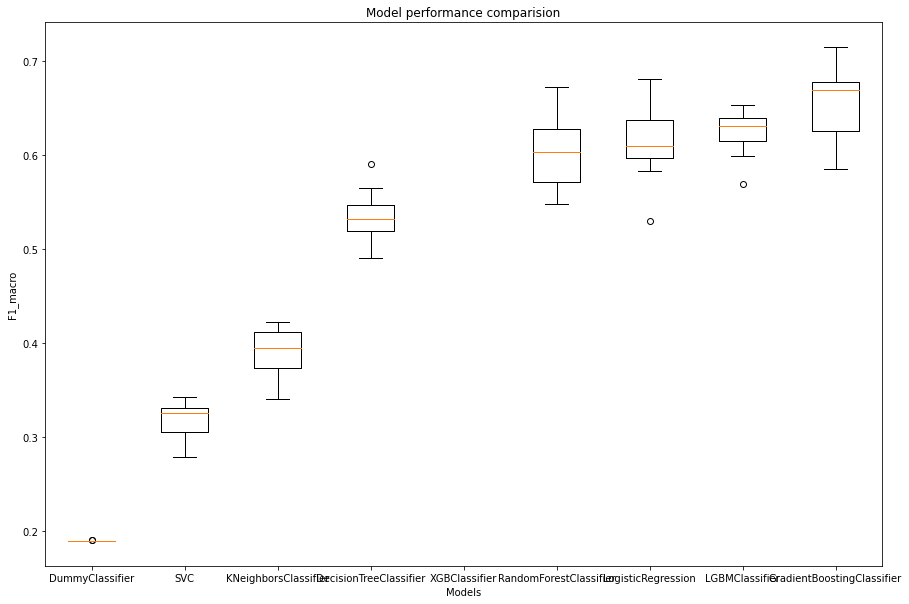

In [239]:
plt.figure(figsize=(15,10))
plt.boxplot(x=results,labels=name)
plt.xlabel('Models')
plt.ylabel('F1_macro')
plt.title('Comparação de performance de modelos')
plt.show()

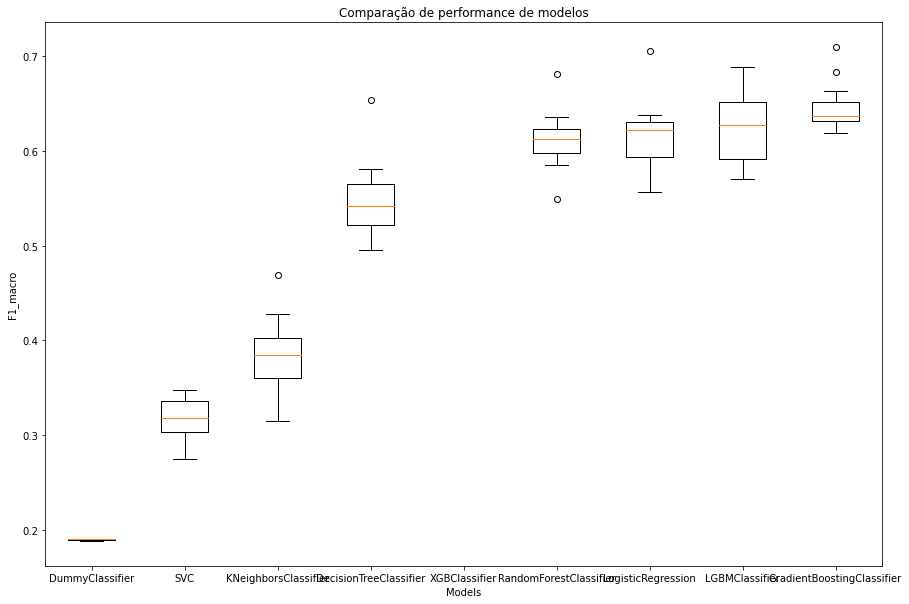

In [297]:
plt.figure(figsize=(15,10))
plt.boxplot(x=results,labels=name)
plt.xlabel('Models')
plt.ylabel('F1_macro')
plt.title('Comparação de performance de modelos')
plt.show()

In [320]:
# X_train_c_p = df_train_c.drop(['position', 'constructor','constructor_confidence'], axis=1)
# y_train_c_p = df_train_c['position']

X_train_c_c = df_train_c.drop(['position', 'driver','driver_confidence'], axis=1)
y_train_c_c = df_train_c['position']

In [321]:
# cross validation for different models
mean_results_dri = []
results_dri = []
name = []
models = [DummyClassifier(), SVC(), KNeighborsClassifier(),  DecisionTreeClassifier(),XGBClassifier(eval_metric='rmse'),RandomForestClassifier(), LogisticRegression(), LGBMClassifier(),GradientBoostingClassifier()]
names = ['DummyClassifier', 'SVC', 'KNeighborsClassifier', 'DecisionTreeClassifier','XGBClassifier', 'RandomForestClassifier', 'LogisticRegression','LGBMClassifier','GradientBoostingClassifier']
model_dict = dict(zip(models,names))
for model in models:
    cv = StratifiedKFold(n_splits=10,random_state=1,shuffle=True)
    result = cross_val_score(model,X_train_c_p,y_train_c_p,cv=cv,scoring='f1_macro')
    mean_results_dri.append(result.mean())
    results_dri.append(result)
    name.append(model_dict[model])
    print(f'{model_dict[model]} : {result.mean()}')

DummyClassifier : 0.18951072284405618
SVC : 0.318934780017681
KNeighborsClassifier : 0.38176922300522714
DecisionTreeClassifier : 0.5288468064368106
XGBClassifier : nan
RandomForestClassifier : 0.6080755920551562
LogisticRegression : 0.6189203565128236
LGBMClassifier : 0.611821945670694
GradientBoostingClassifier : 0.6455779666853951


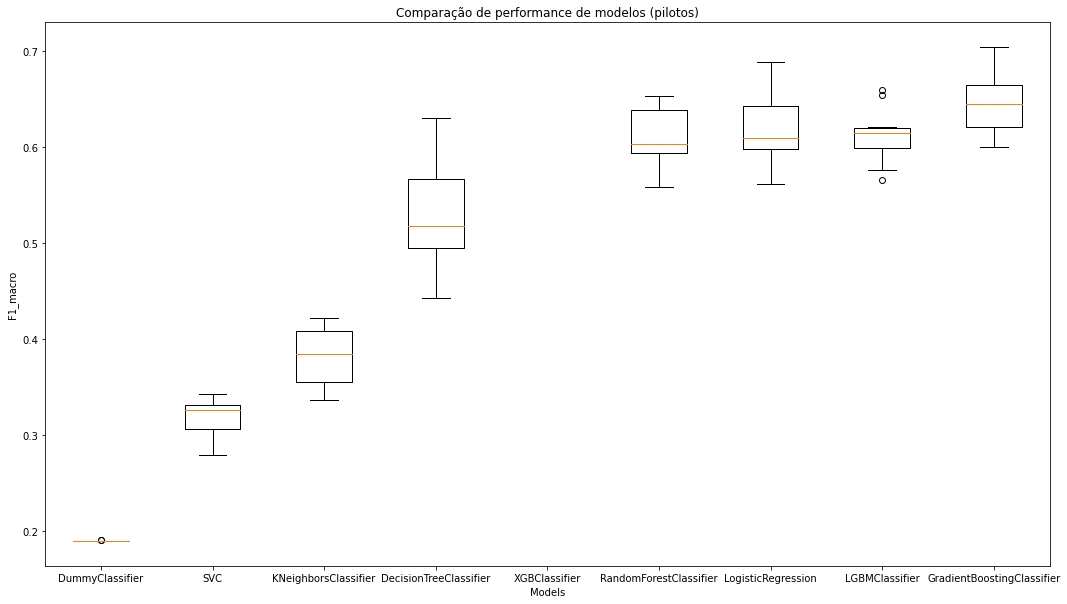

In [322]:
plt.figure(figsize=(18,10))
plt.boxplot(x=results_dri,labels=name)
plt.xlabel('Models')
plt.ylabel('F1_macro')
plt.title('Comparação de performance de modelos (pilotos)')
plt.show()

In [323]:
X_train_c_p = df_train_c.drop(['position', 'constructor','constructor_confidence'], axis=1)
y_train_c_p = df_train_c['position']

In [324]:
mean_results_const = []
results_const = []
name = []
models = [DummyClassifier(), SVC(), KNeighborsClassifier(),  DecisionTreeClassifier(),XGBClassifier(eval_metric='rmse'),RandomForestClassifier(), LogisticRegression(), LGBMClassifier(),GradientBoostingClassifier()]
names = ['DummyClassifier', 'SVC', 'KNeighborsClassifier', 'DecisionTreeClassifier','XGBClassifier', 'RandomForestClassifier', 'LogisticRegression','LGBMClassifier','GradientBoostingClassifier']
model_dict = dict(zip(models,names))
for model in models:
    cv = StratifiedKFold(n_splits=10,random_state=1,shuffle=True)
    result = cross_val_score(model,X_train_c_c,y_train_c_c,cv=cv,scoring='f1_macro')
    mean_results_const.append(result.mean())
    results_const.append(result)
    name.append(model_dict[model])
    print(f'{model_dict[model]} : {result.mean()}')

DummyClassifier : 0.18951072284405618
SVC : 0.318934780017681
KNeighborsClassifier : 0.3893782640400084
DecisionTreeClassifier : 0.5412146630965935
XGBClassifier : nan
RandomForestClassifier : 0.6101315294742954
LogisticRegression : 0.6121585428451073
LGBMClassifier : 0.6187434797404736
GradientBoostingClassifier : 0.6455270689136652


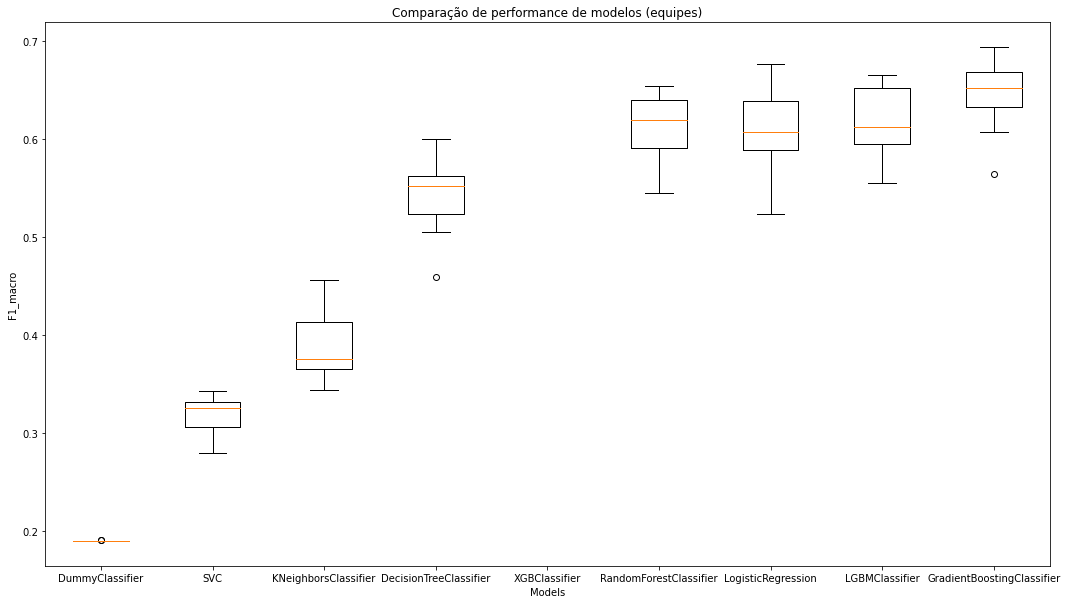

In [325]:
plt.figure(figsize=(18,10))
plt.boxplot(x=results_const,labels=name)
plt.xlabel('Models')
plt.ylabel('F1_macro')
plt.title('Comparação de performance de modelos (equipes)')
plt.show()

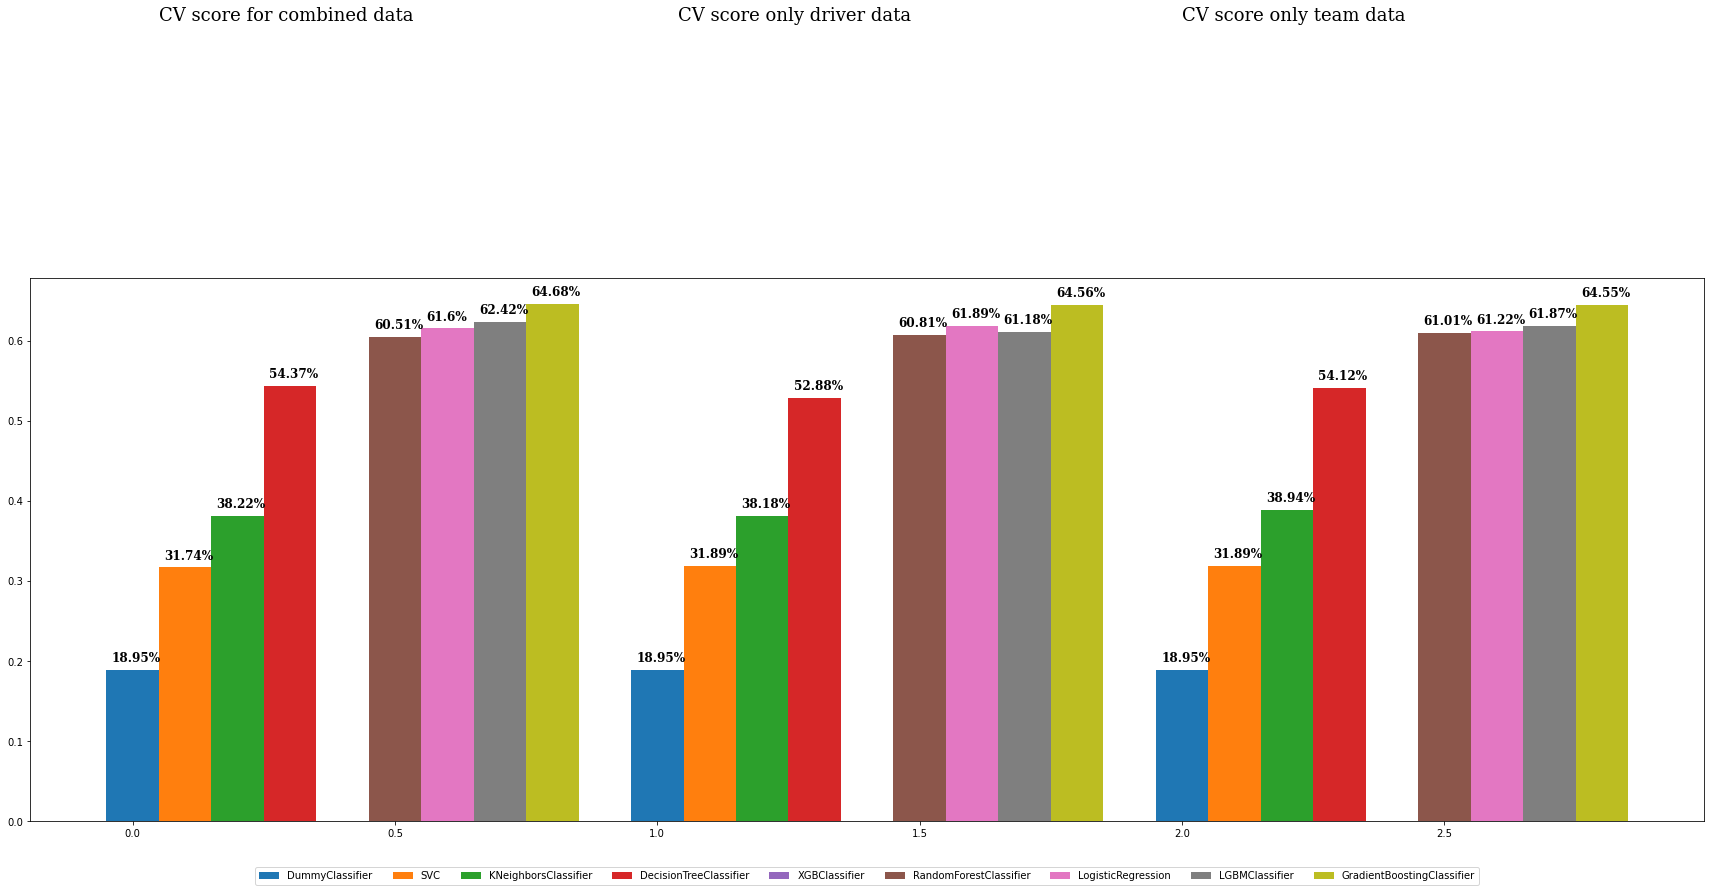

In [329]:
font1 = {
    'family':'serif',
    'color':'black',
    'weight':'normal',
    'size':18
}
font2 = {
    'family':'serif',
    'color':'black',
    'weight':'bold',
    'size':12
}
x_ax = np.arange(3)
plt.figure(figsize=(30,10))
# dm = [mean_results[0],mean_results_dri[0],mean_results_const[0]]
# lgr = [mean_results[1],mean_results_dri[1],mean_results_const[1]]
# dtc = [mean_results[2],mean_results_dri[2],mean_results_const[2]]
# rfc = [mean_results[3],mean_results_dri[3],mean_results_const[3]]
# svc = [mean_results[4],mean_results_dri[4],mean_results_const[4]]
# knn = [mean_results[5],mean_results_dri[5],mean_results_const[5]]
# gbc = [mean_results[6],mean_results_dri[6],mean_results_const[6]]
# xgb = [mean_results[7],mean_results_dri[7],mean_results_const[7]]
# lgbm = [mean_results[8],mean_results_dri[8],mean_results_const[8]]
models = []
names = ['DummyClassifier', 'SVC', 'KNeighborsClassifier', 'DecisionTreeClassifier','XGBClassifier', 'RandomForestClassifier', 'LogisticRegression','LGBMClassifier','GradientBoostingClassifier']

for i in range(len(names)):
    models.append([mean_results[i],mean_results_dri[i],mean_results_const[i]])
bar1 = plt.bar(x_ax,models[0],width=0.1,align='center', label=name[0])
bar2 = plt.bar(x_ax+0.1,models[1],width=0.1,align='center', label=name[1])
bar3 = plt.bar(x_ax+0.2,models[2],width=0.1,align='center',  label=name[2])
bar4 = plt.bar(x_ax+0.3,models[3],width=0.1,align='center', label=name[3])
bar5 = plt.bar(x_ax+0.4,models[4],width=0.1,align='center', label=name[4])
bar6 = plt.bar(x_ax+0.5,models[5],width=0.1,align='center', label=name[5])
bar7 = plt.bar(x_ax+0.6,models[6],width=0.1,align='center', label=name[6])
bar8 = plt.bar(x_ax+0.7,models[7],width=0.1,align='center', label=name[7])
bar9 = plt.bar(x_ax+0.8,models[8],width=0.1,align='center', label=name[8])

plt.text(0.05,1,'CV score for combined data',fontdict=font1)
plt.text(1.04,1,'CV score only driver data',fontdict=font1)
plt.text(2,1,'CV score only team data',fontdict=font1)
for bar in bar1.patches:
    yval = bar.get_height()
    plt.text(bar.get_x()+0.01,yval+0.01,f'{round(yval*100,2)}%',fontdict=font2)
for bar in bar2.patches:
    yval = bar.get_height()
    plt.text(bar.get_x()+0.01,yval+0.01,f'{round(yval*100,2)}%',fontdict=font2)
for bar in bar3.patches:
    yval = bar.get_height()
    plt.text(bar.get_x()+0.01,yval+0.01,f'{round(yval*100,2)}%',fontdict=font2)
for bar in bar4.patches:
    yval = bar.get_height()
    plt.text(bar.get_x()+0.01,yval+0.01,f'{round(yval*100,2)}%',fontdict=font2)
for bar in bar5.patches:
    yval = bar.get_height()
    plt.text(bar.get_x()+0.01,yval+0.01,f'{round(yval*100,2)}%',fontdict=font2)
for bar in bar6.patches:
    yval = bar.get_height()
    plt.text(bar.get_x()+0.01,yval+0.01,f'{round(yval*100,2)}%',fontdict=font2)
for bar in bar7.patches:
    yval = bar.get_height()
    plt.text(bar.get_x()+0.01,yval+0.01,f'{round(yval*100,2)}%',fontdict=font2)
for bar in bar8.patches:
    yval = bar.get_height()
    plt.text(bar.get_x()+0.01,yval+0.01,f'{round(yval*100,2)}%',fontdict=font2)
for bar in bar9.patches:
    yval = bar.get_height()
    plt.text(bar.get_x()+0.01,yval+0.01,f'{round(yval*100,2)}%',fontdict=font2)
plt.legend(loc='center', bbox_to_anchor=(0.5, -0.10), shadow=False, ncol=9)

plt.show()

Nota importante: A tentativa de uso do XGBoost retornou 'nan' em todos os casos. Ao se pesquisar, identificou-se uma limitação do XGBoost no Sagemaker:

"This is an open issue for xgboost. Mostly it's because of invalid libsvm input data (numeric values, Nan, extra spaces somewhere, etc). The distribution engine would simply do a line base split to the file and send partitions to different workers. It might happen that it created some extra line or space when doing the splitting and making the data invalid. XGBoost is very strict regarding to the libsvm input."

Fonte: https://github.com/aws/sagemaker-python-sdk/issues/632

Resultado ao rodar localmente o mesmo código:
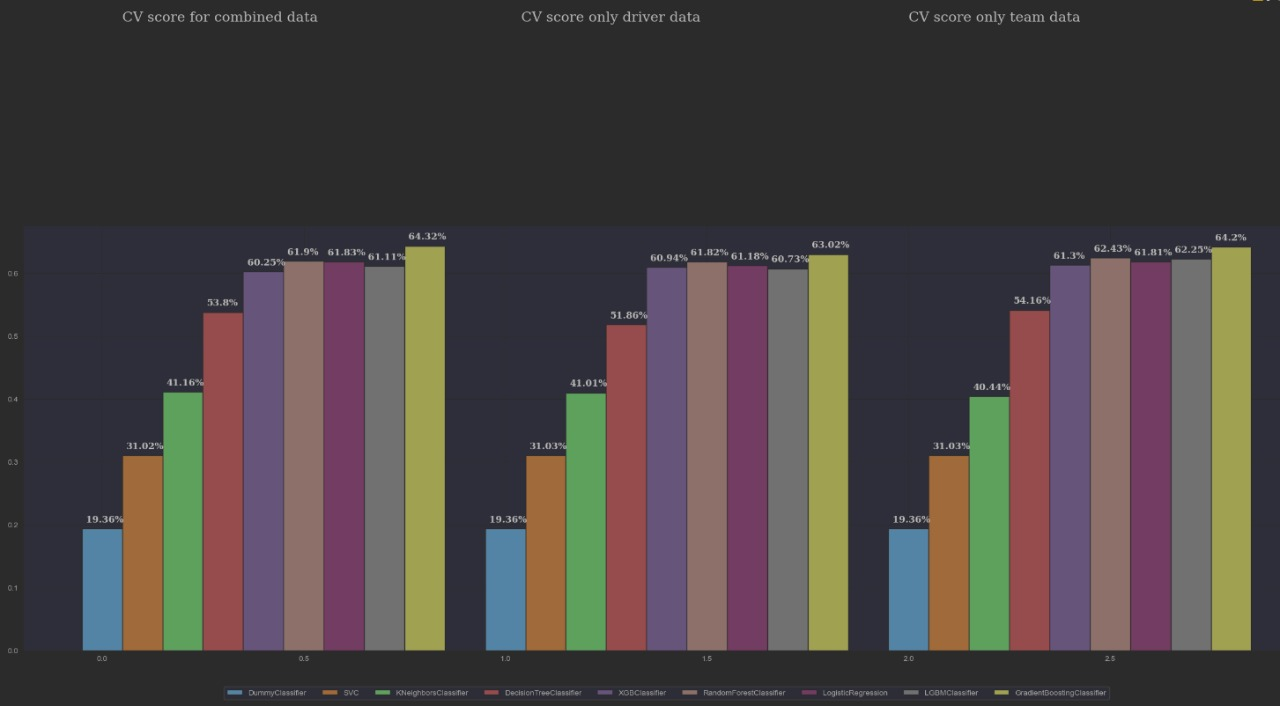

In [361]:
#Deploy
import pickle
def save_obj(obj, name):
    with open('models/'+ name, 'wb') as f:
        pickle.dump(obj, f, pickle.HIGHEST_PROTOCOL)

In [362]:
driver_confidence_dict = dict(zip(df_parc['driver'],df_parc['driver_confidence']))
driver_confidence_dict

{'Valtteri Bottas': 0.95,
 'Guanyu Zhou': 0.9047619047619048,
 'Fernando Alonso': 0.9411764705882353,
 'Sebastian Vettel': 0.9297658862876255,
 'Carlos Sainz': 0.9012345679012346,
 'Charles Leclerc': 0.892156862745098,
 'Lewis Hamilton': 0.941747572815534,
 'George Russell': 0.9259259259259259,
 'Lance Stroll': 0.8925619834710744,
 'Sergio Pérez': 0.9364406779661016,
 'Daniel Ricciardo': 0.9523809523809523,
 'Kevin Magnussen': 0.9290780141843972,
 'Lando Norris': 0.9506172839506173,
 'Nico Hülkenberg': 0.9021739130434783,
 'Alexander Albon': 0.9310344827586207,
 'Nicholas Latifi': 0.8333333333333334,
 'Esteban Ocon': 0.9545454545454546,
 'Max Verstappen': 0.9074074074074074,
 'Pierre Gasly': 0.9345794392523364,
 'Mick Schumacher': 0.9302325581395349,
 'Yuki Tsunoda': 0.9069767441860466,
 'Nyck de Vries': 1.0}

In [363]:
driver_confidence_dict_str = {}
for key , value in driver_confidence_dict.items():
    # Correção para novos pilotos
    if value == 1.0:
        value = 0.10
    driver_confidence_dict_str[key] = np. array([value])
    print ("%s: %s" % (key, value))

save_obj(driver_confidence_dict_str, 'driver_dict' )

Valtteri Bottas: 0.95
Guanyu Zhou: 0.9047619047619048
Fernando Alonso: 0.9411764705882353
Sebastian Vettel: 0.9297658862876255
Carlos Sainz: 0.9012345679012346
Charles Leclerc: 0.892156862745098
Lewis Hamilton: 0.941747572815534
George Russell: 0.9259259259259259
Lance Stroll: 0.8925619834710744
Sergio Pérez: 0.9364406779661016
Daniel Ricciardo: 0.9523809523809523
Kevin Magnussen: 0.9290780141843972
Lando Norris: 0.9506172839506173
Nico Hülkenberg: 0.9021739130434783
Alexander Albon: 0.9310344827586207
Nicholas Latifi: 0.8333333333333334
Esteban Ocon: 0.9545454545454546
Max Verstappen: 0.9074074074074074
Pierre Gasly: 0.9345794392523364
Mick Schumacher: 0.9302325581395349
Yuki Tsunoda: 0.9069767441860466
Nyck de Vries: 0.1


In [364]:
constructor_confidence_dict = dict(zip(df_parc['constructor'], df_parc['constructor_confidence']))
constructor_confidence_dict
constructor_confidence_dict_str = {}
for key, value in constructor_confidence_dict.items():
    # Correct for New Drivers
    if value == 1.0:
        value = 0.10
    constructor_confidence_dict_str[key] = np.array([value])
    print("%s: %s" % (key, value))

save_obj(constructor_confidence_dict_str, 'constructor_dict')

Alfa Romeo: 0.38107202680067
Ferrari: 0.6221178479931682
Mercedes: 0.8635547576301615
Aston Martin: 0.5879396984924623
McLaren: 0.6156369600874795
Williams: 0.5628553379658876
Alpine F1: 0.5452775073028238
Red Bull: 0.776657060518732
AlphaTauri: 0.47560975609756095
Haas F1 Team: 0.3671328671328671


In [366]:
df.head()
df_22 = df[df['year']==2022].sort_values(by='date')
df_22.head()
races = df_22['GP_name'].unique().tolist()
print(races)
drivers = df_22['driver'].unique().tolist()
print(drivers)
constructors = df_22['constructor'].unique().tolist()
print(constructors)

['Bahrain International Circuit', 'Jeddah Corniche Circuit', 'Albert Park Grand Prix Circuit', 'Autodromo Enzo e Dino Ferrari', 'Miami International Autodrome', 'Circuit de Barcelona-Catalunya', 'Circuit de Monaco', 'Baku City Circuit', 'Circuit Gilles Villeneuve', 'Silverstone Circuit', 'Red Bull Ring', 'Circuit Paul Ricard', 'Hungaroring', 'Circuit de Spa-Francorchamps', 'Circuit Park Zandvoort', 'Autodromo Nazionale di Monza', 'Marina Bay Street Circuit', 'Suzuka Circuit', 'Circuit of the Americas', 'Autódromo Hermanos Rodríguez', 'Autódromo José Carlos Pace']
['Lando Norris', 'Pierre Gasly', 'Mick Schumacher', 'Kevin Magnussen', 'Esteban Ocon', 'Fernando Alonso', 'Max Verstappen', 'Sergio Pérez', 'Yuki Tsunoda', 'Nicholas Latifi', 'Daniel Ricciardo', 'Lance Stroll', 'Nico Hülkenberg', 'George Russell', 'Lewis Hamilton', 'Charles Leclerc', 'Carlos Sainz', 'Alexander Albon', 'Guanyu Zhou', 'Valtteri Bottas', 'Sebastian Vettel', 'Nyck de Vries']
['McLaren', 'AlphaTauri', 'Haas F1 Team

In [367]:
results = {'race': [],
          'driver':[],
          'constructor':[],
          'points':[]}
for race in races:
    for driver in drivers:
        clst = df_22.loc[(df_22['GP_name']==race)&(df_22['driver']==driver)]['constructor'].unique().tolist()
        plst = df_22.loc[(df_22['GP_name']==race)&(df_22['driver']==driver)]['points'].unique().tolist()
        for c in clst:
            for p in plst:
                results['race'].append(race)
                results['driver'].append(driver)
                results['constructor'].append(c)
                results['points'].append(p)

In [368]:
df_22_results = pd.DataFrame(results)
print (df_22_results)

                              race            driver   constructor  points
0    Bahrain International Circuit      Lando Norris       McLaren     0.0
1    Bahrain International Circuit      Pierre Gasly    AlphaTauri     0.0
2    Bahrain International Circuit   Mick Schumacher  Haas F1 Team     0.0
3    Bahrain International Circuit   Kevin Magnussen  Haas F1 Team    10.0
4    Bahrain International Circuit      Esteban Ocon     Alpine F1     6.0
..                             ...               ...           ...     ...
415     Autódromo José Carlos Pace      Carlos Sainz       Ferrari    15.0
416     Autódromo José Carlos Pace   Alexander Albon      Williams     0.0
417     Autódromo José Carlos Pace       Guanyu Zhou    Alfa Romeo     0.0
418     Autódromo José Carlos Pace   Valtteri Bottas    Alfa Romeo     2.0
419     Autódromo José Carlos Pace  Sebastian Vettel  Aston Martin     0.0

[420 rows x 4 columns]


In [369]:
print(f'Number of Races done: {len(races)}')

Number of Races done: 21


In [371]:
driver_age_dict = dict(zip(df_22['driver'],df_22['age_at_gp_in_days']))

driver_age_dict_str = {}
for key , value in driver_age_dict.items():
    driver_age_dict_str[key] = np.array([value])
    print ("%s: %s" % (key, value))
    
save_obj(driver_pred_dict_str, 'driver_age_dict' )

Lando Norris: 8401
Pierre Gasly: 9776
Mick Schumacher: 8637
Kevin Magnussen: 10996
Esteban Ocon: 9553
Fernando Alonso: 15082
Max Verstappen: 9175
Sergio Pérez: 11979
Yuki Tsunoda: 8221
Nicholas Latifi: 9999
Daniel Ricciardo: 12188
Lance Stroll: 8781
Nico Hülkenberg: 12639
George Russell: 9037
Lewis Hamilton: 13824
Charles Leclerc: 9159
Carlos Sainz: 10300
Alexander Albon: 9731
Guanyu Zhou: 8568
Valtteri Bottas: 12130
Sebastian Vettel: 12917
Nyck de Vries: 10079


In [372]:
pts_by_driver = df_22_results.groupby('driver').sum()['points']
driver_race = df_22_results.groupby('driver').count()['race']
driver_points_ratio = (pts_by_driver/len(races)/25.0)
driver_points_dict = dict(zip(driver_points_ratio.index,driver_points_ratio))
driver_points_dict

{'Alexander Albon': 0.007619047619047619,
 'Carlos Sainz': 0.4114285714285715,
 'Charles Leclerc': 0.52,
 'Daniel Ricciardo': 0.06095238095238095,
 'Esteban Ocon': 0.1580952380952381,
 'Fernando Alonso': 0.15428571428571428,
 'George Russell': 0.48,
 'Guanyu Zhou': 0.011428571428571429,
 'Kevin Magnussen': 0.04,
 'Lance Stroll': 0.026666666666666665,
 'Lando Norris': 0.2038095238095238,
 'Lewis Hamilton': 0.4438095238095238,
 'Max Verstappen': 0.7771428571428571,
 'Mick Schumacher': 0.022857142857142857,
 'Nicholas Latifi': 0.0038095238095238095,
 'Nico Hülkenberg': 0.0,
 'Nyck de Vries': 0.0038095238095238095,
 'Pierre Gasly': 0.04380952380952381,
 'Sebastian Vettel': 0.06857142857142856,
 'Sergio Pérez': 0.5257142857142857,
 'Valtteri Bottas': 0.08952380952380952,
 'Yuki Tsunoda': 0.022857142857142857}

In [373]:
pts_by_constructor = df_22_results.groupby('constructor').sum()['points']
constructor_race = df_22_results.groupby('constructor').count()['race']
constructor_pts_ratio = (pts_by_constructor/len(races)/(25.0+18.0))
constructor_points_dict = dict(zip(constructor_pts_ratio.index,constructor_pts_ratio))
constructor_points_dict

{'Alfa Romeo': 0.058693244739756366,
 'AlphaTauri': 0.03875968992248062,
 'Alpine F1': 0.18161683277962348,
 'Aston Martin': 0.05537098560354374,
 'Ferrari': 0.5415282392026578,
 'Haas F1 Team': 0.03654485049833887,
 'McLaren': 0.1539313399778516,
 'Mercedes': 0.5370985603543743,
 'Red Bull': 0.7574750830564784,
 'Williams': 0.008859357696566999}

In [374]:
driver_pred_dict_str = {}
for key , value in driver_points_dict.items():
    driver_pred_dict_str[key] = np.array([value])
    print ("%s: %s" % (key, value))

save_obj(driver_pred_dict_str, 'driver_pred_dict' )

Alexander Albon: 0.007619047619047619
Carlos Sainz: 0.4114285714285715
Charles Leclerc: 0.52
Daniel Ricciardo: 0.06095238095238095
Esteban Ocon: 0.1580952380952381
Fernando Alonso: 0.15428571428571428
George Russell: 0.48
Guanyu Zhou: 0.011428571428571429
Kevin Magnussen: 0.04
Lance Stroll: 0.026666666666666665
Lando Norris: 0.2038095238095238
Lewis Hamilton: 0.4438095238095238
Max Verstappen: 0.7771428571428571
Mick Schumacher: 0.022857142857142857
Nicholas Latifi: 0.0038095238095238095
Nico Hülkenberg: 0.0
Nyck de Vries: 0.0038095238095238095
Pierre Gasly: 0.04380952380952381
Sebastian Vettel: 0.06857142857142856
Sergio Pérez: 0.5257142857142857
Valtteri Bottas: 0.08952380952380952
Yuki Tsunoda: 0.022857142857142857


In [375]:
constructor_pred_dict_str = {}
for key, value in constructor_points_dict.items():
    constructor_pred_dict_str[key] = np.array([value])
    #print ("%s: %s" % (key, value))
    
save_obj(constructor_pred_dict_str, 'constructor_pred_dict')

In [348]:
qualif = {'race': [],
         'driver': [],
         'quali_pos': []
         }
for race in races:
    for driver in drivers:
        qlst = df_22.loc[(df_22['GP_name'] == race) & (df_22['driver'] == driver)][
            'quali_pos'].unique().tolist()
        for q in qlst:
            qualif['race'].append(race)
            qualif['driver'].append(driver)
            qualif['quali_pos'].append(q)

df_22_qualif = pd.DataFrame(qualif)
print(df_22_qualif)

                              race            driver  quali_pos
0    Bahrain International Circuit      Lando Norris         13
1    Bahrain International Circuit      Pierre Gasly         10
2    Bahrain International Circuit   Mick Schumacher         12
3    Bahrain International Circuit   Kevin Magnussen          7
4    Bahrain International Circuit      Esteban Ocon         11
..                             ...               ...        ...
415     Autódromo José Carlos Pace      Carlos Sainz          7
416     Autódromo José Carlos Pace   Alexander Albon         19
417     Autódromo José Carlos Pace       Guanyu Zhou         13
418     Autódromo José Carlos Pace   Valtteri Bottas         14
419     Autódromo José Carlos Pace  Sebastian Vettel          9

[420 rows x 3 columns]


In [349]:
df_22_qualif.to_csv('./datasets/qualif_filtered.csv', index=False)
# last race
last_race = races[len(races) - 1]
print(last_race)

Autódromo José Carlos Pace


In [350]:
qualif_last= df_22_qualif[df_22_qualif['race']==last_race]
print (qualif_last)

                           race            driver  quali_pos
400  Autódromo José Carlos Pace      Lando Norris          6
401  Autódromo José Carlos Pace      Pierre Gasly         10
402  Autódromo José Carlos Pace   Mick Schumacher         12
403  Autódromo José Carlos Pace   Kevin Magnussen          8
404  Autódromo José Carlos Pace      Esteban Ocon         16
405  Autódromo José Carlos Pace   Fernando Alonso         17
406  Autódromo José Carlos Pace    Max Verstappen          3
407  Autódromo José Carlos Pace      Sergio Pérez          4
408  Autódromo José Carlos Pace      Yuki Tsunoda          0
409  Autódromo José Carlos Pace   Nicholas Latifi         18
410  Autódromo José Carlos Pace  Daniel Ricciardo         11
411  Autódromo José Carlos Pace      Lance Stroll         15
412  Autódromo José Carlos Pace    George Russell          1
413  Autódromo José Carlos Pace    Lewis Hamilton          2
414  Autódromo José Carlos Pace   Charles Leclerc          5
415  Autódromo José Carl

In [351]:
print(qualif_last)
qualif_last.to_csv('./datasets/qualif_lastrace.csv', index=False)

                           race            driver  quali_pos
400  Autódromo José Carlos Pace      Lando Norris          6
401  Autódromo José Carlos Pace      Pierre Gasly         10
402  Autódromo José Carlos Pace   Mick Schumacher         12
403  Autódromo José Carlos Pace   Kevin Magnussen          8
404  Autódromo José Carlos Pace      Esteban Ocon         16
405  Autódromo José Carlos Pace   Fernando Alonso         17
406  Autódromo José Carlos Pace    Max Verstappen          3
407  Autódromo José Carlos Pace      Sergio Pérez          4
408  Autódromo José Carlos Pace      Yuki Tsunoda          0
409  Autódromo José Carlos Pace   Nicholas Latifi         18
410  Autódromo José Carlos Pace  Daniel Ricciardo         11
411  Autódromo José Carlos Pace      Lance Stroll         15
412  Autódromo José Carlos Pace    George Russell          1
413  Autódromo José Carlos Pace    Lewis Hamilton          2
414  Autódromo José Carlos Pace   Charles Leclerc          5
415  Autódromo José Carl

<a id="subsection_4_2"></a> 
## 4.2 Tuning do modelo
Nessa fase, partimos para a defição e ajustes nos hiperparâmetros para otimizar o processo de treinamento.

In [352]:
def save_model(model, model_filepath):
    filename = model_filepath
    pickle.dump(model, open(filename, 'wb'))

def position_index(x):
    if x<4:
        return 3
    if x>10:
        return 1
    else :
        return 2

In [353]:
n_estimators = [int(x) for x in np.linspace(start=200, stop=2000, num=10)]
max_features = ['auto', 'sqrt']
max_depth = [int(x) for x in np.linspace(10, 110, num=11)]
min_samples_split = [2, 5, 8, 10, 15, 20]
min_samples_leaf = [1, 2, 4, 6, 8, 10]

random_parms = {
    'n_estimators': n_estimators,
    'max_features': max_features,
    'max_depth': max_depth,
    'min_samples_split': min_samples_split,
    'min_samples_leaf': min_samples_leaf
}

In [354]:
x = pd.read_csv('./datasets/data_clean.csv')
x.head()

,GP_name,quali_pos,driver,age_at_gp_in_days,position,driver_confidence,constructor,constructor_confidence,weather_warm,weather_cold,weather_dry,weather_wet,weather_cloudy
0,Silverstone Circuit,3,Fernando Alonso,10574,14.0,0.941176,Ferrari,0.622118,1,0,0,0,0
1,Silverstone Circuit,3,Fernando Alonso,10938,1.0,0.941176,Ferrari,0.622118,0,0,0,1,0
2,Silverstone Circuit,1,Fernando Alonso,11302,2.0,0.941176,Ferrari,0.622118,0,0,0,0,0
3,Silverstone Circuit,9,Fernando Alonso,11659,3.0,0.941176,Ferrari,0.622118,0,0,1,0,0
4,Silverstone Circuit,16,Fernando Alonso,12030,6.0,0.941176,Ferrari,0.622118,0,0,0,0,1


In [355]:
le = LabelEncoder()
x['GP_name'] = le.fit_transform(x['GP_name'])
x['constructor'] = le.fit_transform(x['constructor'])
x['driver'] = le.fit_transform(x['driver'])
x['GP_name'] = le.fit_transform(x['GP_name'])
X = x.drop(['position'], 1)
y = x['position'].apply(lambda x: position_index(x))

In [357]:
rf_rand = GradientBoostingClassifier()
rf_random = RandomizedSearchCV(estimator=rf_rand, param_distributions=random_parms, n_iter=1, cv=10, verbose=2,
                               n_jobs=-1)
rf_random.fit(X, y)
rf_random.best_params_

Fitting 10 folds for each of 1 candidates, totalling 10 fits


{'n_estimators': 1200,
 'min_samples_split': 10,
 'min_samples_leaf': 2,
 'max_features': 'sqrt',
 'max_depth': 50}

best parameters - fitting 10 folds for each of 100 candidates, tottaling 1000 fits
{'n_estimators': 400,
 'min_samples_split': 5,
 'min_samples_leaf': 1,
 'max_features': 'auto',
 'max_depth': 80}

In [358]:
rf = GradientBoostingClassifier(n_estimators=400, min_samples_split=5, min_samples_leaf=1, max_features='auto',
                                max_depth=80)
kf = StratifiedKFold(n_splits=10, random_state=None, shuffle=False)
for train_index, test_index in kf.split(X, y):
    X_train, X_test = X.iloc[train_index], X.iloc[test_index]
    y_train, y_test = y.iloc[train_index], y.iloc[test_index]
rf.fit(X_train, y_train)
y_pred_rf = rf.predict(X_test)
cnf_mat_rf = confusion_matrix(y_test, y_pred_rf)
cnf_mat_rf = cnf_mat_rf / cnf_mat_rf.sum()
cnf_mat_rf

array([[0.10566038, 0.10188679, 0.01509434],
       [0.09433962, 0.36226415, 0.09056604],
       [0.00377358, 0.06792453, 0.15849057]])

[CV] END max_depth=50, max_features=sqrt, min_samples_leaf=2, min_samples_split=10, n_estimators=1200; total time=  26.7s
[CV] END max_depth=50, max_features=sqrt, min_samples_leaf=2, min_samples_split=10, n_estimators=1200; total time=  28.2s
[CV] END max_depth=50, max_features=sqrt, min_samples_leaf=2, min_samples_split=10, n_estimators=1200; total time=  26.5s
[CV] END max_depth=50, max_features=sqrt, min_samples_leaf=2, min_samples_split=10, n_estimators=1200; total time=  26.3s
[CV] END max_depth=50, max_features=sqrt, min_samples_leaf=2, min_samples_split=10, n_estimators=1200; total time=  26.9s
[CV] END max_depth=50, max_features=sqrt, min_samples_leaf=2, min_samples_split=10, n_estimators=1200; total time=  26.9s
[CV] END max_depth=50, max_features=sqrt, min_samples_leaf=2, min_samples_split=10, n_estimators=1200; total time=  28.0s
[CV] END max_depth=50, max_features=sqrt, min_samples_leaf=2, min_samples_split=10, n_estimators=1200; total time=  26.7s
[CV] END max_depth=50, m

In [360]:
model_filepath = './models/{}.pkl'.format('GradientBoostingClassifier')
print('Saving model ...\n    MODEL: {}'.format(model_filepath))
save_model(rf, model_filepath)

Saving model ...
    MODEL: ./models/GradientBoostingClassifier.pkl


<a id="subsection_4_3"></a> 
## 4.3 Evaluate do modelo

In [376]:
import pickle
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import LabelEncoder

import warnings
warnings.filterwarnings("ignore")

model_filepath='./models/{}.pkl'.format('GradientBoostingClassifier')

#Carregar modelo usando pickle l from disk
print('Loading model ...\n    MODEL: {}'.format(model_filepath))
loaded_model = pickle.load(open(model_filepath, 'rb'))
#model = joblib.load(model_filepath)

Loading model ...
    MODEL: ./models/GradientBoostingClassifier.pkl


In [377]:
def position_index(x):
    if x<4:
        return 3
    if x>10:
        return 1
    else :
        return 2

In [378]:
data = pd.read_csv('./datasets/data_clean.csv')
x=data.copy()
le = LabelEncoder()
x['GP_name'] = le.fit_transform(x['GP_name'])
x['constructor'] = le.fit_transform(x['constructor'])
x['driver'] = le.fit_transform(x['driver'])
x['GP_name'] = le.fit_transform(x['GP_name'])
X = x.drop(['position'],axis=1)
y = x['position'].apply(lambda x: position_index(x))

In [379]:
feature_names=X.columns
feature_names

Index(['GP_name', 'quali_pos', 'driver', 'age_at_gp_in_days',
       'driver_confidence', 'constructor', 'constructor_confidence',
       'weather_warm', 'weather_cold', 'weather_dry', 'weather_wet',
       'weather_cloudy'],
      dtype='object')

In [380]:
#Desvio padrão da importância das features
std = np.std([
    tree[0].feature_importances_ for tree in loaded_model.estimators_], axis=0)
std

array([0.09805998, 0.08468109, 0.02402104, 0.19715292, 0.02267847,
       0.01766299, 0.01943154, 0.01079434, 0.00023999, 0.00768435,
       0.00950555, 0.0113338 ])

In [381]:
importances = loaded_model.feature_importances_
importances

array([1.63949677e-01, 3.09111759e-01, 3.77187964e-02, 2.98441798e-01,
       3.99050526e-02, 3.72928082e-02, 4.16517940e-02, 1.83960364e-02,
       5.81216808e-05, 1.49818125e-02, 2.10850651e-02, 1.74072798e-02])

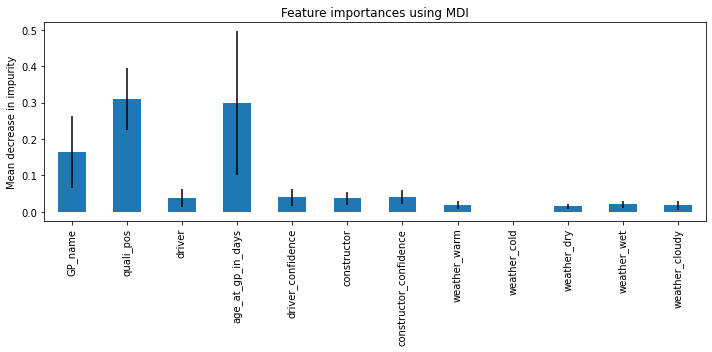

In [388]:
gradient_importances = pd.Series(importances, index=feature_names)

fig, ax = plt.subplots(figsize=(10,5))
gradient_importances.plot.bar(yerr=std, ax=ax)
ax.set_title("Feature importances using MDI")
ax.set_ylabel("Mean decrease in impurity")
fig.tight_layout()

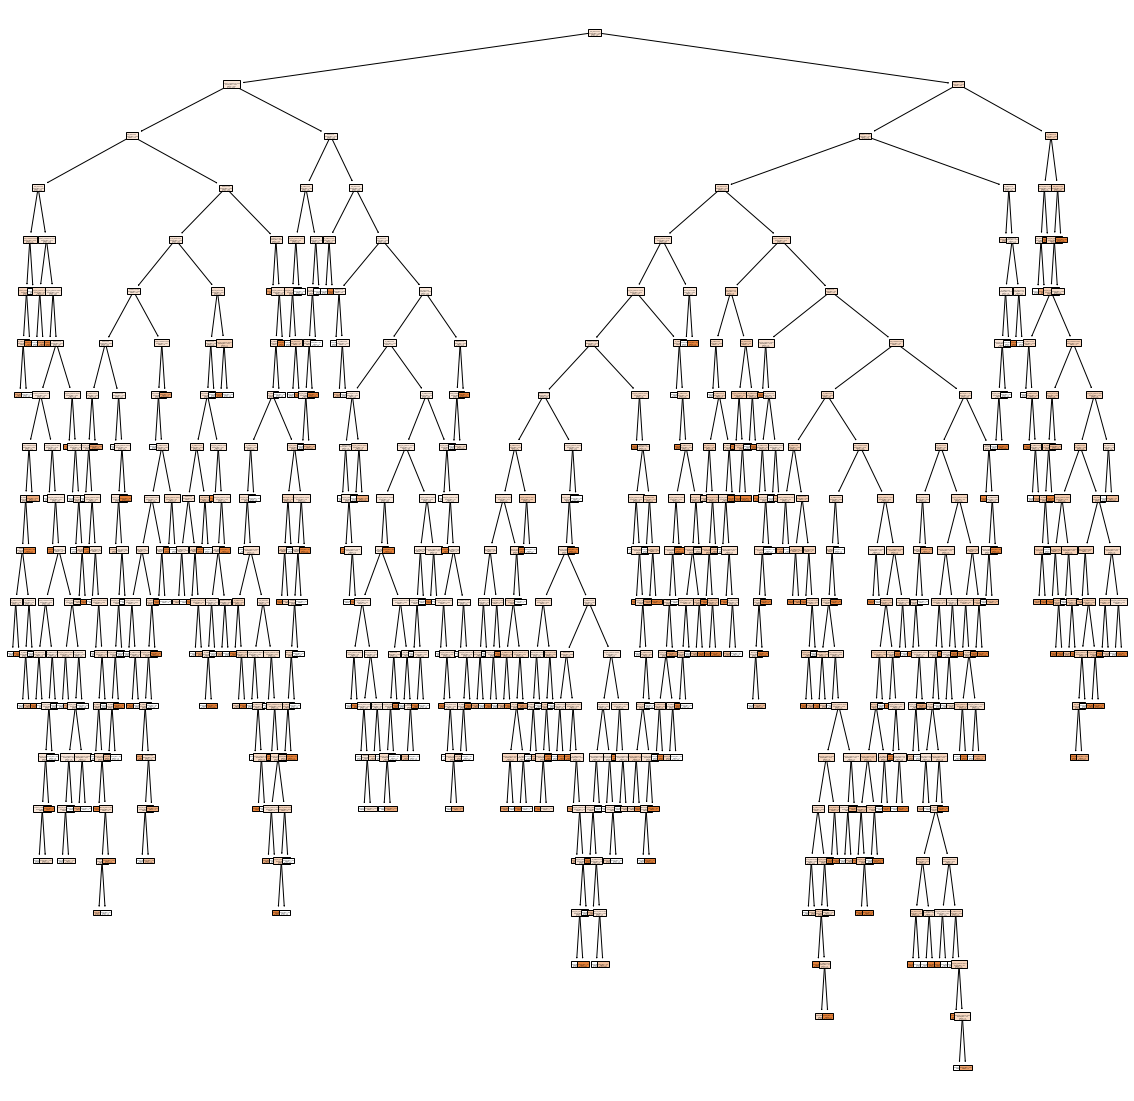

In [383]:
from sklearn import tree
plt.figure(figsize=(20,20))
_ = tree.plot_tree(loaded_model.estimators_[0][0], feature_names=feature_names, filled=True)

In [389]:
len(loaded_model.estimators_)

400

In [390]:
loaded_model.estimators_[0][0].tree_.max_depth

20

In [391]:
#Dicionário usado pelo ML Model hypothesis
driver_dict = pickle.load(open('./models/driver_dict','rb'))
constructor_dict = pickle.load(open('./models/constructor_dict','rb'))
driver_age = pickle.load(open('./models/driver_age_dict','rb'))

# Predições para cada corrida
driver_pred_dict = pickle.load(open('./models/driver_pred_dict','rb'))
constructor_pred_dict = pickle.load(open('./models/constructor_pred_dict','rb'))

# Dataset gerado
data = pd.read_csv('./datasets/data_clean.csv')
qualif = pd.read_csv('./datasets/qualif_filtered.csv')


#lastqualif = pd.read_csv('./datasets/qualif_lastrace.csv')
##Testar a qualificacao de Yas Marina - Inserido manual pois não estava na Base de dados ainda.
lastqualif = pd.DataFrame({'race':['Yas Marina Circuit'],'driver':['Max Verstappen'],'quali_pos':[1]})
lastqualif.loc[len(lastqualif)] = ['Yas Marina Circuit', 'Charles Leclerc',3]
lastqualif.loc[len(lastqualif)] = ['Yas Marina Circuit', 'Lewis Hamilton',5]
lastqualif.loc[len(lastqualif)] = ['Yas Marina Circuit','George Russell',6]
lastqualif.loc[len(lastqualif)] = ['Yas Marina Circuit', 'Alexander Albon',19]
lastqualif.loc[len(lastqualif)] = ['Yas Marina Circuit', 'Nicholas Latifi', 20]
lastqualif.loc[len(lastqualif)] = ['Yas Marina Circuit','Daniel Ricciardo', 13]
lastqualif.loc[len(lastqualif)] = ['Yas Marina Circuit','Pierre Gasly', 17]
lastqualif.loc[len(lastqualif)] = ['Yas Marina Circuit','Lando Norris',7]
lastqualif.loc[len(lastqualif)] = ['Yas Marina Circuit', 'Mick Schumacher', 12]
lastqualif.loc[len(lastqualif)] = ['Yas Marina Circuit', 'Fernando Alonso', 10]
lastqualif.loc[len(lastqualif)] = ['Yas Marina Circuit','Esteban Ocon',8]
lastqualif.loc[len(lastqualif)] = ['Yas Marina Circuit', 'Valtteri Bottas', 18]
lastqualif.loc[len(lastqualif)] = ['Yas Marina Circuit', 'Guanyu Zhou', 15]
lastqualif.loc[len(lastqualif)] = ['Yas Marina Circuit','Sergio Pérez',2]
lastqualif.loc[len(lastqualif)] = ['Yas Marina Circuit','Carlos Sainz',4]
lastqualif.loc[len(lastqualif)] = ['Yas Marina Circuit','Yuki Tsunoda', 11]
lastqualif.loc[len(lastqualif)] = ['Yas Marina Circuit', 'Kevin Magnussen', 16]
lastqualif.loc[len(lastqualif)] = ['Yas Marina Circuit','Lance Stroll', 14]
lastqualif.loc[len(lastqualif)] = ['Yas Marina Circuit','Sebastian Vettel',9]
print(lastqualif.tail())
#for i in range(len(lastqualif))
# Model loaded
clf = pickle.load(open('./models/GradientBoostingClassifier.pkl','rb'))
y_dict = {3:'Podium Finish',
          2:'Points Finish',
          1:'No Points Finish'
        }

le_d = LabelEncoder()
le_d.fit(data['driver'])
le_c = LabelEncoder()
le_c.fit(data['constructor'])
le_gp = LabelEncoder()
le_gp.fit(data['GP_name'])

                  race            driver  quali_pos
15  Yas Marina Circuit      Carlos Sainz          4
16  Yas Marina Circuit      Yuki Tsunoda         11
17  Yas Marina Circuit   Kevin Magnussen         16
18  Yas Marina Circuit      Lance Stroll         14
19  Yas Marina Circuit  Sebastian Vettel          9


LabelEncoder()

In [392]:
def pred(driver,constructor,quali,circuit,weather):
    weather_warm=0
    weather_cold=0
    weather_dry=0
    weather_wet=0
    weather_cloudy=0
    if weather=='warm':
        weather_warm=1
    elif weather=='cold':
         weather_cold=1
    elif weather=='dry':
         weather_dry=1
    elif weather=='wet':
        weather_wet=1
    elif weather=='cloudy':
        weather_cloudy=1

    gp = le_gp.fit_transform([circuit]).max()
    quali_pos = quali
    constructor_enc = le_c.transform([constructor]).max()
    driver_confidence = driver_dict[driver].max()
    constructor_reliability = constructor_dict[constructor].max()
    driver_age_in_race = driver_age[driver].max()
    driver_enc = le_d.transform([driver]).max()
    prediction = clf.predict([[gp,quali_pos,driver_enc,driver_age_in_race,driver_confidence,constructor_enc,constructor_reliability,weather_warm,weather_cold,weather_dry,weather_wet,weather_cloudy]]).max()
    #print(clf.predict([[gp,quali_pos,constructor_enc,driver_enc,driver_confidence,constructor_reliability]]))
    #return y_dict[prediction]
    return prediction, driver_confidence, constructor_reliability

def getproba(driver,constructor):
    driver_proba = driver_pred_dict[driver].max()
    constructor_proba = constructor_pred_dict[constructor].max()
    return driver_proba, constructor_proba

def getQualifData(circuit, driver):
    df = qualif[(qualif['race']==circuit) & (qualif['driver']==driver)]
    qlst = df['quali_pos'].tolist()
    if len(qlst) > 0:
        return qlst[0]
    else :
        df = lastqualif[(qualif['driver']==driver)]
        qlst = df['quali_pos'].tolist()
        return qlst[0]

In [397]:
active_drivers = [['Daniel Ricciardo','McLaren'],
                  ['Mick Schumacher','Haas F1 Team'],
                  ['Carlos Sainz','Ferrari'],
                  ['George Russell','Mercedes'],
                  ['Lance Stroll','Aston Martin'],
                  ['Alexander Albon','Williams'],
                  ['Lando Norris','McLaren'],
                  ['Sebastian Vettel','Aston Martin'],
                  ['Valtteri Bottas','Alfa Romeo'],
                  ['Charles Leclerc','Ferrari'],
                  ['Lewis Hamilton','Mercedes'],
                  ['Yuki Tsunoda','AlphaTauri'],
                  ['Max Verstappen','Red Bull'],
                  ['Pierre Gasly','AlphaTauri'],
                  ['Fernando Alonso','Alpine F1'],
                  ['Sergio Pérez','Red Bull'],
                  ['Esteban Ocon','Alpine F1'],
                  ['Kevin Magnussen','Haas F1 Team'],
                  ['Nicholas Latifi','Williams']]

def predict_position(circuit, weather):
    #res = predictor.pred(circuit, weather)
    res = []
    for row in active_drivers:
        #for elem in row:
        driver = row[0]
        constructor = row[1]
        quali = getQualifData(circuit, driver)
        my_rangeprediction, driver_confidence, constructor_reliability = pred(driver,constructor,quali,circuit,weather)
        #print ("%s: %s : %s : %s : %s " % (driver, constructor, my_rangeprediction, driver_confidence, constructor_reliability))
        driverproba, constructorproba = getproba(driver,constructor)
        #predpercentage = "{:.2%}".format(driverproba)
        elem = [driver, constructor, my_rangeprediction, driver_confidence, constructor_reliability, driverproba]
        res.append(elem)

    #print (res)
    df = pd.DataFrame(res, columns = ['Driver','Constructor','podium', 'driver_confidence', 'constructor_reliability', 'Prediction'] )
    #Filter only Drivers with Podium probability
    df1 = df[df['podium']==3]
    df1 = df1.sort_values(['Prediction'], ascending=False)
    if len(df1) < 11 :
        df2 = df[df['podium']==2]
        df2 = df2.sort_values(['Prediction'], ascending=False).head(11-len(df1))
        df1 = df1.append(df2)
    df1 = df1.drop(['Constructor', 'podium'],axis=1)
    df1 = df1.sort_values(['Prediction'], ascending=False)
    return df1

In [398]:
#Inserir o nome do último circuito para prever o próximo.
predict_position('Autódromo José Carlos Pace','dry')

,Driver,driver_confidence,constructor_reliability,Prediction
12,Max Verstappen,0.907407,0.776657,0.777143
9,Charles Leclerc,0.892157,0.622118,0.520000
3,George Russell,0.925926,0.863555,0.480000
10,Lewis Hamilton,0.941748,0.863555,0.443810
2,Carlos Sainz,0.901235,0.622118,0.411429
6,Lando Norris,0.950617,0.615637,0.203810
14,Fernando Alonso,0.941176,0.545278,0.154286
8,Valtteri Bottas,0.950000,0.381072,0.089524
7,Sebastian Vettel,0.929766,0.587940,0.068571
0,Daniel Ricciardo,0.952381,0.615637,0.060952


#### Resultado real da corrida (20/07/2022):

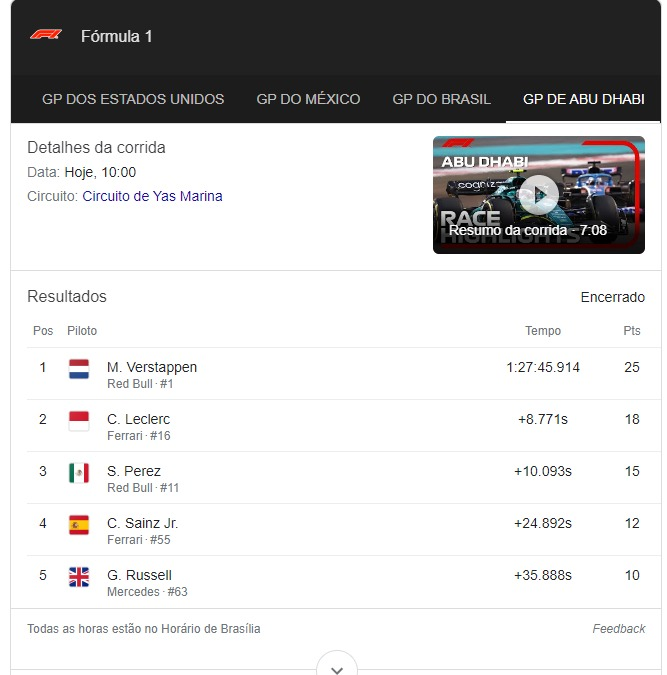

<a id="subsection_4_4"></a> 
## 4.4 Resultado de previsão do modelo

| Posição | Resultado da corrida | Resultado do modelo | Acertou? |
| --- | --- | --- | --- |
| 1º | M. Verstappen | M. Verstappen | Sim |
| 2º | C. Leclerc | C. Leclerc | Sim |
| 3º | S. Perez | G. Russell | Não |
| 4º | C. Sainz | L. Hamilton | Não |
| 5º | G. Russell | C. Sainz | Não |

O modelos acertou os dois primeiros colocados da corrida. Um detalhe a se acrescentar é que o piloto Lewis Hamilton não finalizou a corrida devido a um incidente que ocorreu no início e danificou o carro.

In [3]:
from sklearn.metrics import accuracy_score

y_true = ['Max Verstappen', 'Charles Leclerc','Sergio Pérez','Carlos Sainz','George Russell','Lando Norris','Esteban Ocon','Lance Stroll','Daniel Ricciardo','Sebastian Vettel','Pierre Gasly']
y_pred = ['Max Verstappen', 'Charles Leclerc','George Russell','Lewis Hamilton','Carlos Sainz','Lando Norris','Fernando Alonso','Valtteri Bottas','Sebastian Vettel','Daniel Ricciardo','Pierre Gasly']

accuracy_score(y_true, y_pred)

0.36363636363636365

<a id="section_5"></a> 
# 5. Deploy do modelo

----
Para o deploy dos modelos, produtizou-se através da função Pickle. Um objeto Pickle permite que possamos utilizá-lo em produção. O código mostrado na sequência foi utilizado em seções anteriores após obtenção de resultados finais.

In [ ]:
# import pickle
# def save_obj(obj, name):
#     with open('models/'+ name, 'wb') as f:
#         pickle.dump(obj, f, pickle.HIGHEST_PROTOCOL)

# model_filepath = './models/{}.pkl'.format('GradientBoostingClassifier')
# print('Saving model ...\n    MODEL: {}'.format(model_filepath))
# save_model(rf, model_filepath)

<a id="section_6"></a> 
# 6. Experimentação com Sagemaker Canvas

----
O Sagemaker Canvas é uma interface visual user-friendly e pode ser usado sem qualquer conhecimento prévio de aprendizado de máquina ou conhecimento de codificação. Dessa forma, testou-se a ferramenta (disponível na aws) como uso experimental. A acurácia obtida com o Sagemaker Canvas doi de 66,5%, enquanto  

1. Import dos datasets (arquivos .CSV)
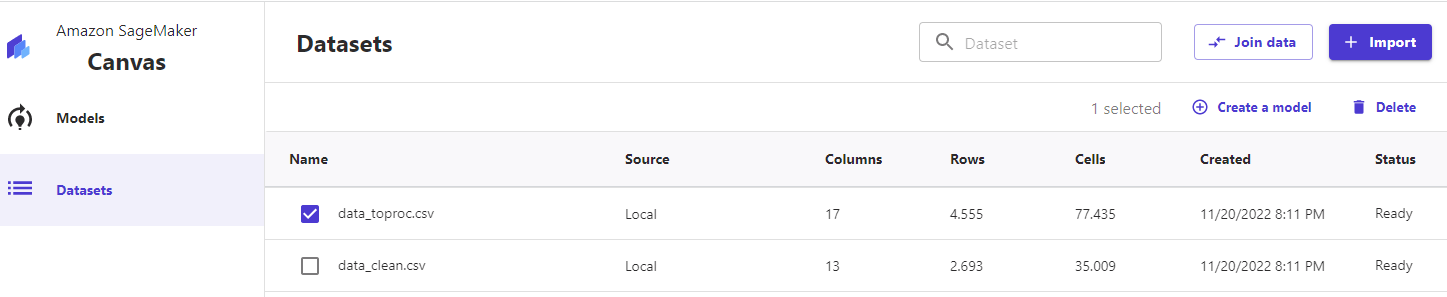

2. Predição

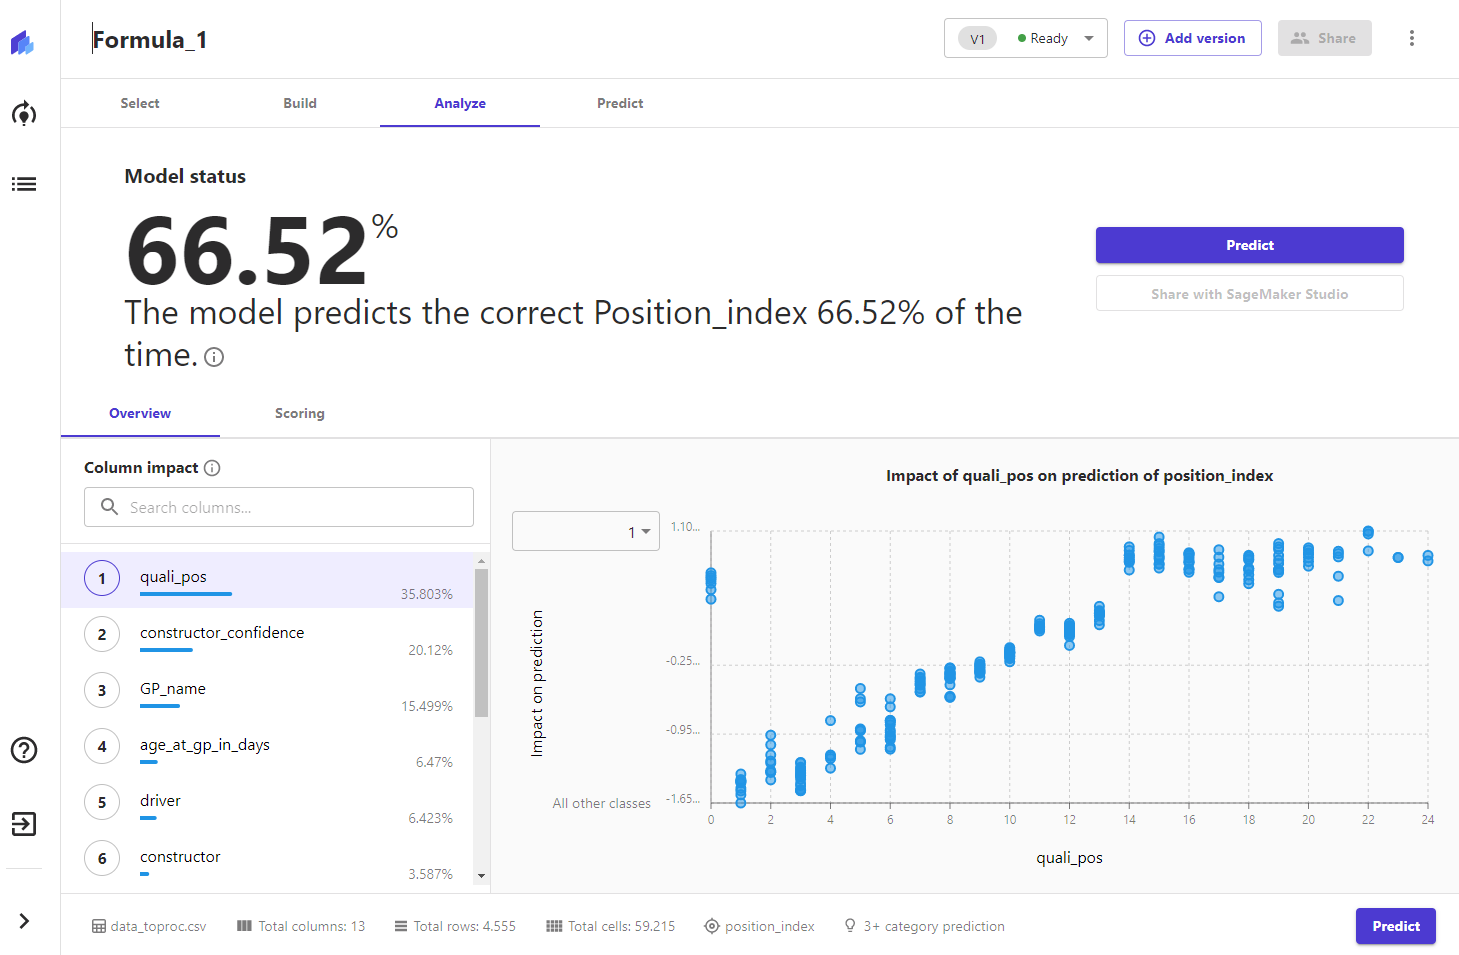